In [1]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

C:\Users\biswsu1\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('../AudioWAV/')
dir_list.sort()

### Sentences:

It's eleven o'clock (IEO). <br>
That is exactly what happened (TIE). <br>
I'm on my way to the meeting (IOM). <br>
I wonder what this is about (IWW). <br>
The airplane is almost full (TAI). <br>
Maybe tomorrow it will be cold (MTI). <br>
I would like a new alarm clock (IWL) <br>
I think I have a doctor's appointment (ITH). <br>
Don't forget a jacket (DFA). <br>
I think I've seen this before (ITS). <br>
The surface is slick (TSI). <br>
We'll stop in a couple of minutes (WSI). <br>

### Emotions:

Anger (ANG) <br>
Disgust (DIS) <br>
Fear (FEA) <br>
Happy/Joy (HAP) <br>
Neutral (NEU) <br>
Sad (SAD) <br>

### Level
Low (LO) <br>
Medium (MD) <br>
High (HI) <br>
Unspecified (XX) <br>

In [3]:
dir_list[0]

'1001_DFA_ANG_XX.wav'

In [4]:
# Create DataFrame for Data intel
df = pd.DataFrame(columns=['path', 'actor', 'gender','intensity', 'statement', 'emotion'])

count = 0

for i in dir_list:
    nm = i.split("_")
    path = '../AudioWAV/' + i
    actor = nm[0]
    statement = nm[1]
    emotion = nm[2]
    intensity = nm[3].split(".")[0]
    if int(actor) >= 1049:
        gender = "female"
    else:
        gender = "male"
            
    df.loc[count] = [path, actor, gender, intensity, statement, emotion]
    count += 1

In [5]:
df.head()

,path,actor,gender,intensity,statement,emotion
0,../AudioWAV/1001_DFA_ANG_XX.wav,1001,male,XX,DFA,ANG
1,../AudioWAV/1001_DFA_DIS_XX.wav,1001,male,XX,DFA,DIS
2,../AudioWAV/1001_DFA_FEA_XX.wav,1001,male,XX,DFA,FEA
3,../AudioWAV/1001_DFA_HAP_XX.wav,1001,male,XX,DFA,HAP
4,../AudioWAV/1001_DFA_NEU_XX.wav,1001,male,XX,DFA,NEU


In [6]:
len(df)

7442

In [7]:
filename = df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

../AudioWAV/1013_IWW_NEU_XX.wav


(22050, array([ 2.6419104e-04,  3.5802430e-05, -2.7152000e-04, ...,
         1.5600528e-04,  1.2293330e-04,  0.0000000e+00], dtype=float32))

In [8]:
len(samples), sample_rate

(58123, 22050)

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [10]:
sample_rate/ len(samples)

0.3793678922285498

Text(0.5,0,'Seconds')

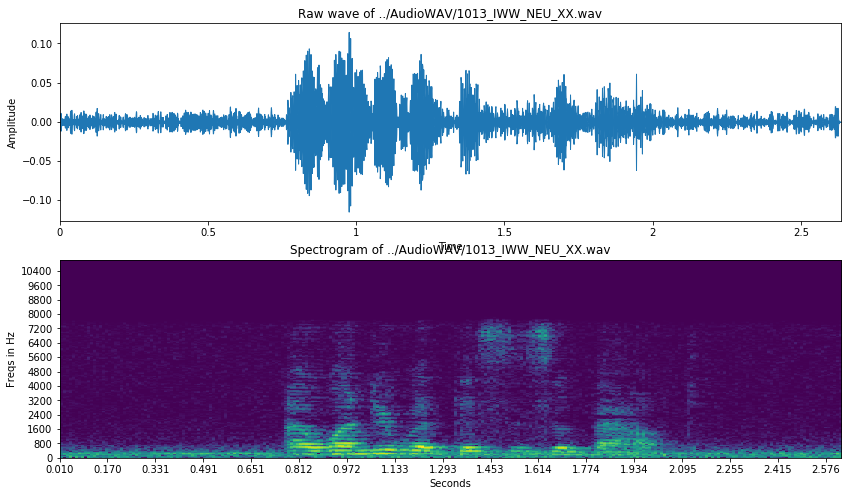

In [11]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [12]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [13]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=13)
aa, bb

(array([-0.00238423, -0.00169365, -0.00099868, ..., -0.01242722,
        -0.01117711, -0.01110893], dtype=float32), array([16896, 44544]))

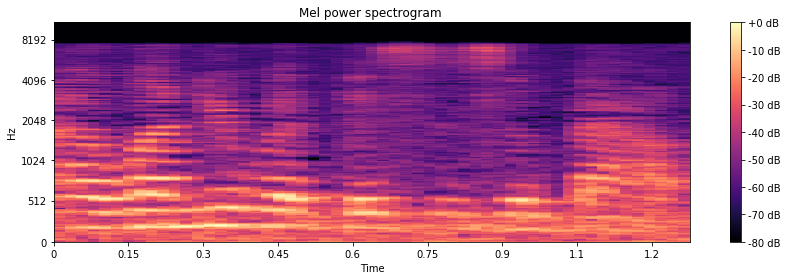

In [14]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=256)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\biswsu1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



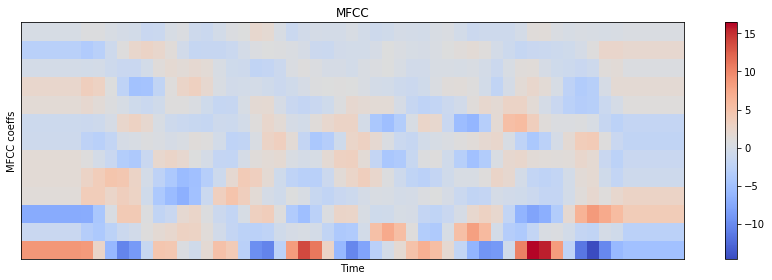

In [15]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [16]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [17]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [18]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# Define Labels

### Emotions:

Anger (ANG) <br>
Disgust (DIS) <br>
Fear (FEA) <br>
Happy/Joy (HAP) <br>
Neutral (NEU) <br>
Sad (SAD) <br>

### Level
Low (LO) <br>
Medium (MD) <br>
High (HI) <br>
Unspecified (XX) <br>

In [19]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(df)):
    if df.emotion[i] == 'NEU': # Neutral
        lb = "_positive"
    elif df.emotion[i] == 'HAP': # Happy
        lb = "_positive"
    elif df.emotion[i] == 'SAD': # Sad
        lb = "_negative"
    elif df.emotion[i] == 'ANG': # Angry
        lb = "_negative"
    elif df.emotion[i] == 'FEA': # Fearful
        lb = "_negative"
    elif df.emotion[i] == 'DIS': # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(df.gender[i] + lb)
    
len(label2_list)

7442

In [20]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label3_list = []
for i in range(len(df)):
    if df.emotion[i] == 'NEU': # Neutral
        lb = "_neutral"
    elif df.emotion[i] == 'HAP': # Happy
        lb = "_positive"
    elif df.emotion[i] == 'SAD': # Sad
        lb = "_negative"
    elif df.emotion[i] == 'ANG': # Angry
        lb = "_negative"
    elif df.emotion[i] == 'FEA': # Fearful
        lb = "_negative"
    elif df.emotion[i] == 'DIS': # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label3_list.append(df.gender[i] + lb)
    
len(label3_list)

7442

In [21]:
# 6 class: angry, neutral, sad, happy, fearful & disgust
label5_list = []
for i in range(len(df)):
    if df.emotion[i] == 'NEU':
        lb = "_neutral"
    elif df.emotion[i] == 'HAP':
        lb = "_happy"
    elif df.emotion[i] == 'SAD':
        lb = "_sad"
    elif df.emotion[i] == 'ANG':
        lb = "_angry"
    elif df.emotion[i] == 'FEA':
        lb = "_fearful"    
    elif df.emotion[i] == 'DIS':
        lb = "_disgust"   
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(df.gender[i] + lb)
    
len(label5_list)

7442

In [22]:
# Select the label set you want by commenting the unwanteds.

df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
df.head()

,path,actor,gender,intensity,statement,emotion,label
0,../AudioWAV/1001_DFA_ANG_XX.wav,1001,male,XX,DFA,ANG,male_negative
1,../AudioWAV/1001_DFA_DIS_XX.wav,1001,male,XX,DFA,DIS,male_negative
2,../AudioWAV/1001_DFA_FEA_XX.wav,1001,male,XX,DFA,FEA,male_negative
3,../AudioWAV/1001_DFA_HAP_XX.wav,1001,male,XX,DFA,HAP,male_positive
4,../AudioWAV/1001_DFA_NEU_XX.wav,1001,male,XX,DFA,NEU,male_positive


In [23]:
print (df.label.value_counts())

male_negative      2676
female_negative    2408
male_positive      1241
female_positive    1117
Name: label, dtype: int64


In [24]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

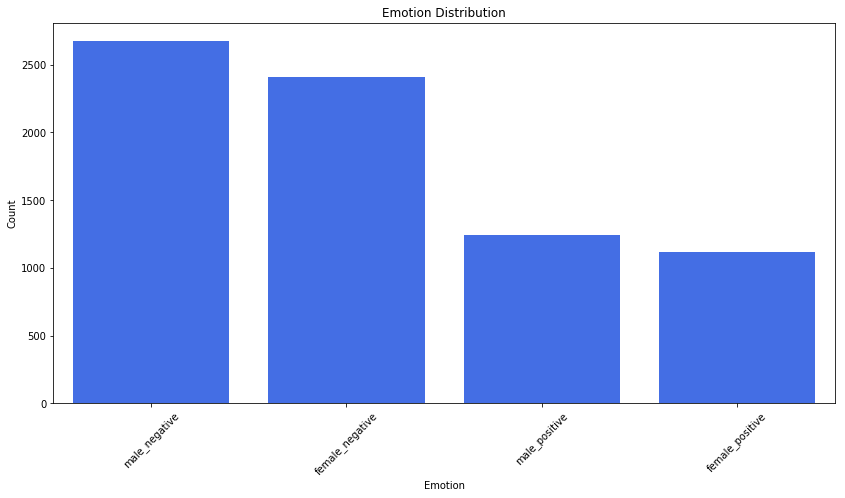

In [25]:
a = df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# Data Splitting

In [26]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [27]:
print (df.label.value_counts())

male_negative      2676
female_negative    2408
male_positive      1241
female_positive    1117
Name: label, dtype: int64


In [28]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = df.copy()
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

3917


,path,actor,gender,intensity,statement,emotion,label
0,../AudioWAV/1001_DFA_ANG_XX.wav,1001,male,XX,DFA,ANG,male_negative
1,../AudioWAV/1001_DFA_DIS_XX.wav,1001,male,XX,DFA,DIS,male_negative
2,../AudioWAV/1001_DFA_FEA_XX.wav,1001,male,XX,DFA,FEA,male_negative
3,../AudioWAV/1001_DFA_HAP_XX.wav,1001,male,XX,DFA,HAP,male_positive
4,../AudioWAV/1001_DFA_NEU_XX.wav,1001,male,XX,DFA,NEU,male_positive


In [29]:
data2_df.label.unique()

array(['male_negative', 'male_positive'], dtype=object)

In [30]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████████████████████████████████████████████████████████████████████████| 3917/3917 [02:49<00:00, 23.15it/s]


In [31]:
data.head()

,feature
0,"[-2.4000943, -4.3289294, -12.644746, -14.01838..."
1,"[-22.564024, -22.701225, -21.290754, -19.64806..."
2,"[-20.928806, -21.371073, -19.40437, -22.236254..."
3,"[-16.398293, -14.678077, -15.696125, -15.37671..."
4,"[-9.55192, -11.677659, -18.698666, -19.993986,..."


In [32]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [33]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
newdf = pd.concat([df3,labels], axis=1)

In [35]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

3917

In [36]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
5,-14.271524,-14.306529,-17.609734,-20.602913,-18.980045,-18.795036,-20.786684,-19.505970,-19.449627,-20.241711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
6,1.104802,-1.703769,-12.059550,-11.033955,-11.973175,-12.566163,-11.687649,-10.513777,-11.607019,-13.376740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
7,-13.307253,-12.211918,-12.965446,-12.433738,-15.644149,-15.768937,-13.861085,-14.858727,-16.347948,-15.930140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
8,-23.222227,-20.179287,-22.090635,-22.374855,-21.120758,-19.788216,-19.642355,-19.581688,-19.134932,-18.029387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
9,-11.435347,-12.344702,-14.309602,-15.758933,-16.117149,-15.936514,-17.034607,-15.341814,-13.512670,-11.805071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative


In [37]:
rnewdf.isnull().sum().sum()

318889

In [38]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


# Data Augmentation

In [39]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

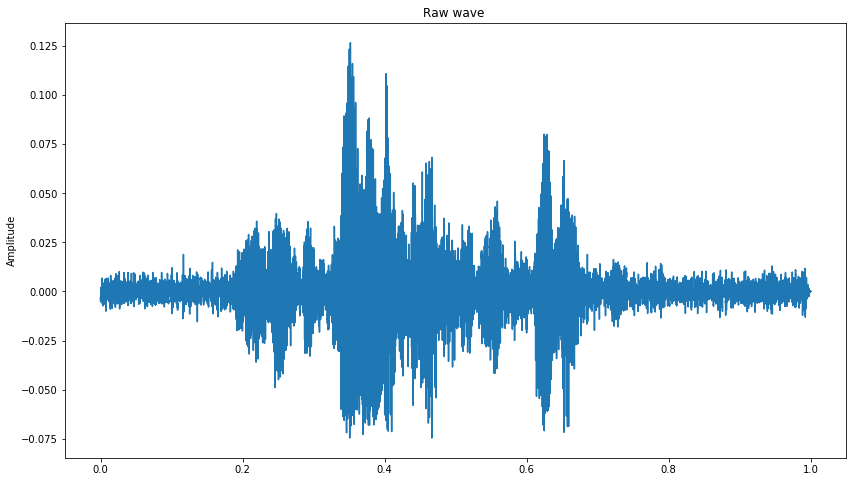

In [40]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

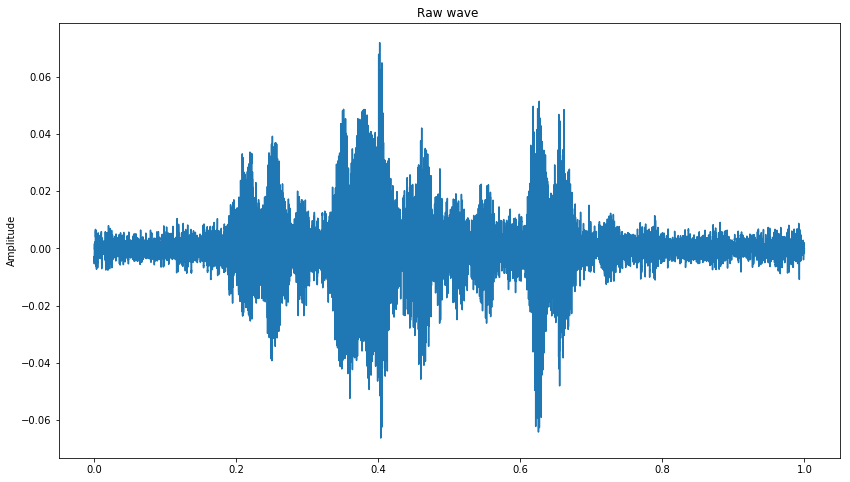

In [41]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [42]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████████████████████████████████████████████| 3917/3917 [02:44<00:00, 23.88it/s]


In [43]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████████████████████████████████████████████| 3917/3917 [14:34<00:00,  4.12it/s]


In [44]:
len(syn_data1), len(syn_data2)

(3917, 3917)

In [45]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [46]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

3917

In [47]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.122633,-3.761298,-12.058997,-13.365656,-13.991774,-14.121975,-14.101732,-15.134247,-13.648829,-12.904787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-20.560154,-20.584492,-19.633419,-18.468643,-19.502062,-16.732399,-13.217921,-10.018278,-10.381721,-10.391135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-19.210764,-19.369507,-17.823875,-20.936625,-22.611137,-21.976631,-18.736980,-12.627349,-7.521833,-6.641561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-15.617976,-13.928859,-14.978133,-14.798110,-14.199224,-14.872000,-15.007365,-13.801668,-15.245793,-16.073677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-9.276742,-11.384375,-18.373913,-19.748484,-19.227583,-20.470055,-21.931759,-21.428337,-18.336277,-17.046995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [48]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

3917

In [49]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.432518,-5.878911,-16.162539,-17.477562,-20.465715,-21.703386,-20.287682,-19.152763,-20.314787,-19.278421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-23.427269,-23.495472,-24.381680,-24.539440,-21.449638,-20.465105,-19.470600,-17.189785,-16.732830,-15.559422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-22.316864,-23.206505,-22.751875,-24.866699,-25.513918,-25.004295,-19.944942,-15.836639,-13.776078,-12.460491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-17.091543,-17.087900,-20.412258,-21.296864,-19.786600,-19.458742,-19.923155,-20.894447,-20.040791,-20.220531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-11.275709,-13.882235,-22.033405,-21.846462,-21.477314,-23.319201,-25.384298,-24.123573,-21.397739,-21.495504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [50]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

In [52]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [53]:
y_train.value_counts()

male_negative    6422
male_positive    2978
Name: label, dtype: int64

In [54]:
y_test.value_counts()

male_negative    1606
male_positive     745
Name: label, dtype: int64

In [55]:
X_train.isna().sum().sum()

0

In [56]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [57]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [58]:
X_train.shape

(9400, 259)

# Changing dimension for CNN model

In [59]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [60]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [191]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.adam(lr=0.00001)

In [192]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_151 (Conv1D)          (None, 259, 256)          2304      
_________________________________________________________________
activation_172 (Activation)  (None, 259, 256)          0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_39 (Batc (None, 259, 256)          1024      
_________________________________________________________________
activation_173 (Activation)  (None, 259, 256)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 32, 256)           0         
__________

In [194]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [200]:
x_testcnn

7442

In [201]:
x_traincnn.shape, x_testcnn.shape

((9400, 259, 1), (2351, 259, 1))

In [195]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
early_callback = keras.callbacks.EarlyStopping(patience=5, monitor='loss')
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('../models/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=256, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce, early_callback], verbose=1)

Train on 9400 samples, validate on 2351 samples
Epoch 1/700
9400/9400 [==============================] - ETA: 4:18 - loss: 0.7643 - acc: 0.4023 - fscore: 0.40 - ETA: 2:09 - loss: 0.7416 - acc: 0.4219 - fscore: 0.42 - ETA: 1:25 - loss: 0.7198 - acc: 0.4688 - fscore: 0.46 - ETA: 1:03 - loss: 0.7067 - acc: 0.5010 - fscore: 0.50 - ETA: 50s - loss: 0.7016 - acc: 0.5156 - fscore: 0.5156 - ETA: 41s - loss: 0.6863 - acc: 0.5475 - fscore: 0.547 - ETA: 35s - loss: 0.6810 - acc: 0.5608 - fscore: 0.560 - ETA: 30s - loss: 0.6717 - acc: 0.5767 - fscore: 0.576 - ETA: 26s - loss: 0.6674 - acc: 0.5877 - fscore: 0.587 - ETA: 23s - loss: 0.6635 - acc: 0.5973 - fscore: 0.597 - ETA: 20s - loss: 0.6609 - acc: 0.6040 - fscore: 0.604 - ETA: 18s - loss: 0.6591 - acc: 0.6094 - fscore: 0.609 - ETA: 16s - loss: 0.6559 - acc: 0.6163 - fscore: 0.616 - ETA: 15s - loss: 0.6598 - acc: 0.6161 - fscore: 0.616 - ETA: 13s - loss: 0.6559 - acc: 0.6232 - fscore: 0.623 - ETA: 12s - loss: 0.6561 - acc: 0.6243 - fscore: 0.624 

9400/9400 [==============================] - ETA: 5s - loss: 0.6243 - acc: 0.6484 - fscore: 0.64 - ETA: 5s - loss: 0.6116 - acc: 0.6602 - fscore: 0.66 - ETA: 4s - loss: 0.6070 - acc: 0.6758 - fscore: 0.67 - ETA: 4s - loss: 0.6034 - acc: 0.6699 - fscore: 0.66 - ETA: 4s - loss: 0.5935 - acc: 0.6844 - fscore: 0.68 - ETA: 4s - loss: 0.5921 - acc: 0.6875 - fscore: 0.68 - ETA: 4s - loss: 0.5918 - acc: 0.6869 - fscore: 0.68 - ETA: 4s - loss: 0.5925 - acc: 0.6860 - fscore: 0.68 - ETA: 4s - loss: 0.5915 - acc: 0.6879 - fscore: 0.68 - ETA: 3s - loss: 0.5891 - acc: 0.6883 - fscore: 0.68 - ETA: 3s - loss: 0.5892 - acc: 0.6889 - fscore: 0.68 - ETA: 3s - loss: 0.5941 - acc: 0.6842 - fscore: 0.68 - ETA: 3s - loss: 0.6007 - acc: 0.6785 - fscore: 0.67 - ETA: 3s - loss: 0.6019 - acc: 0.6791 - fscore: 0.67 - ETA: 3s - loss: 0.6015 - acc: 0.6805 - fscore: 0.68 - ETA: 3s - loss: 0.6013 - acc: 0.6797 - fscore: 0.67 - ETA: 2s - loss: 0.5985 - acc: 0.6831 - fscore: 0.68 - ETA: 2s - loss: 0.5970 - acc: 0.6845 

9400/9400 [==============================] - ETA: 5s - loss: 0.5652 - acc: 0.6953 - fscore: 0.69 - ETA: 4s - loss: 0.5741 - acc: 0.6973 - fscore: 0.69 - ETA: 4s - loss: 0.5794 - acc: 0.6888 - fscore: 0.68 - ETA: 4s - loss: 0.5782 - acc: 0.6914 - fscore: 0.69 - ETA: 4s - loss: 0.5760 - acc: 0.6914 - fscore: 0.69 - ETA: 4s - loss: 0.5782 - acc: 0.6914 - fscore: 0.69 - ETA: 4s - loss: 0.5803 - acc: 0.6897 - fscore: 0.68 - ETA: 4s - loss: 0.5760 - acc: 0.6909 - fscore: 0.69 - ETA: 4s - loss: 0.5769 - acc: 0.6949 - fscore: 0.69 - ETA: 3s - loss: 0.5767 - acc: 0.6957 - fscore: 0.69 - ETA: 3s - loss: 0.5801 - acc: 0.6942 - fscore: 0.69 - ETA: 3s - loss: 0.5768 - acc: 0.6992 - fscore: 0.69 - ETA: 3s - loss: 0.5786 - acc: 0.6983 - fscore: 0.69 - ETA: 3s - loss: 0.5817 - acc: 0.6961 - fscore: 0.69 - ETA: 3s - loss: 0.5817 - acc: 0.6958 - fscore: 0.69 - ETA: 3s - loss: 0.5807 - acc: 0.6956 - fscore: 0.69 - ETA: 2s - loss: 0.5819 - acc: 0.6955 - fscore: 0.69 - ETA: 2s - loss: 0.5848 - acc: 0.6916 

9400/9400 [==============================] - ETA: 5s - loss: 0.5845 - acc: 0.6797 - fscore: 0.67 - ETA: 5s - loss: 0.5870 - acc: 0.6777 - fscore: 0.67 - ETA: 4s - loss: 0.5776 - acc: 0.6940 - fscore: 0.69 - ETA: 4s - loss: 0.5829 - acc: 0.6875 - fscore: 0.68 - ETA: 4s - loss: 0.5705 - acc: 0.7047 - fscore: 0.70 - ETA: 4s - loss: 0.5674 - acc: 0.7044 - fscore: 0.70 - ETA: 4s - loss: 0.5721 - acc: 0.6964 - fscore: 0.69 - ETA: 4s - loss: 0.5717 - acc: 0.6992 - fscore: 0.69 - ETA: 4s - loss: 0.5648 - acc: 0.7040 - fscore: 0.70 - ETA: 3s - loss: 0.5626 - acc: 0.7066 - fscore: 0.70 - ETA: 3s - loss: 0.5603 - acc: 0.7088 - fscore: 0.70 - ETA: 3s - loss: 0.5673 - acc: 0.7018 - fscore: 0.70 - ETA: 3s - loss: 0.5707 - acc: 0.7007 - fscore: 0.70 - ETA: 3s - loss: 0.5727 - acc: 0.6978 - fscore: 0.69 - ETA: 3s - loss: 0.5707 - acc: 0.7008 - fscore: 0.70 - ETA: 3s - loss: 0.5731 - acc: 0.6990 - fscore: 0.69 - ETA: 2s - loss: 0.5739 - acc: 0.6969 - fscore: 0.69 - ETA: 2s - loss: 0.5766 - acc: 0.6944 

9400/9400 [==============================] - ETA: 5s - loss: 0.6119 - acc: 0.7227 - fscore: 0.72 - ETA: 5s - loss: 0.5877 - acc: 0.7109 - fscore: 0.71 - ETA: 4s - loss: 0.5814 - acc: 0.7031 - fscore: 0.70 - ETA: 4s - loss: 0.5885 - acc: 0.6904 - fscore: 0.69 - ETA: 4s - loss: 0.5856 - acc: 0.6914 - fscore: 0.69 - ETA: 4s - loss: 0.5790 - acc: 0.6992 - fscore: 0.69 - ETA: 4s - loss: 0.5775 - acc: 0.7037 - fscore: 0.70 - ETA: 4s - loss: 0.5805 - acc: 0.7012 - fscore: 0.70 - ETA: 4s - loss: 0.5770 - acc: 0.7027 - fscore: 0.70 - ETA: 3s - loss: 0.5779 - acc: 0.7027 - fscore: 0.70 - ETA: 3s - loss: 0.5809 - acc: 0.6982 - fscore: 0.69 - ETA: 3s - loss: 0.5806 - acc: 0.6989 - fscore: 0.69 - ETA: 3s - loss: 0.5814 - acc: 0.6959 - fscore: 0.69 - ETA: 3s - loss: 0.5805 - acc: 0.6964 - fscore: 0.69 - ETA: 3s - loss: 0.5811 - acc: 0.6964 - fscore: 0.69 - ETA: 3s - loss: 0.5784 - acc: 0.6982 - fscore: 0.69 - ETA: 2s - loss: 0.5773 - acc: 0.6994 - fscore: 0.69 - ETA: 2s - loss: 0.5773 - acc: 0.6992 

9400/9400 [==============================] - ETA: 5s - loss: 0.5797 - acc: 0.6953 - fscore: 0.69 - ETA: 5s - loss: 0.5584 - acc: 0.7031 - fscore: 0.70 - ETA: 4s - loss: 0.5480 - acc: 0.7266 - fscore: 0.72 - ETA: 4s - loss: 0.5554 - acc: 0.7207 - fscore: 0.72 - ETA: 4s - loss: 0.5615 - acc: 0.7102 - fscore: 0.71 - ETA: 4s - loss: 0.5652 - acc: 0.7083 - fscore: 0.70 - ETA: 4s - loss: 0.5675 - acc: 0.7048 - fscore: 0.70 - ETA: 4s - loss: 0.5661 - acc: 0.7061 - fscore: 0.70 - ETA: 4s - loss: 0.5627 - acc: 0.7114 - fscore: 0.71 - ETA: 3s - loss: 0.5612 - acc: 0.7105 - fscore: 0.71 - ETA: 3s - loss: 0.5614 - acc: 0.7070 - fscore: 0.70 - ETA: 3s - loss: 0.5631 - acc: 0.7064 - fscore: 0.70 - ETA: 3s - loss: 0.5650 - acc: 0.7037 - fscore: 0.70 - ETA: 3s - loss: 0.5644 - acc: 0.7068 - fscore: 0.70 - ETA: 3s - loss: 0.5635 - acc: 0.7096 - fscore: 0.70 - ETA: 3s - loss: 0.5645 - acc: 0.7083 - fscore: 0.70 - ETA: 2s - loss: 0.5641 - acc: 0.7098 - fscore: 0.70 - ETA: 2s - loss: 0.5636 - acc: 0.7112 

9400/9400 [==============================] - ETA: 5s - loss: 0.5415 - acc: 0.7227 - fscore: 0.72 - ETA: 5s - loss: 0.5570 - acc: 0.7227 - fscore: 0.72 - ETA: 4s - loss: 0.5540 - acc: 0.7188 - fscore: 0.71 - ETA: 4s - loss: 0.5482 - acc: 0.7246 - fscore: 0.72 - ETA: 4s - loss: 0.5508 - acc: 0.7172 - fscore: 0.71 - ETA: 4s - loss: 0.5492 - acc: 0.7148 - fscore: 0.71 - ETA: 4s - loss: 0.5425 - acc: 0.7215 - fscore: 0.72 - ETA: 4s - loss: 0.5484 - acc: 0.7158 - fscore: 0.71 - ETA: 4s - loss: 0.5474 - acc: 0.7188 - fscore: 0.71 - ETA: 3s - loss: 0.5487 - acc: 0.7168 - fscore: 0.71 - ETA: 3s - loss: 0.5467 - acc: 0.7198 - fscore: 0.71 - ETA: 3s - loss: 0.5481 - acc: 0.7184 - fscore: 0.71 - ETA: 3s - loss: 0.5461 - acc: 0.7169 - fscore: 0.71 - ETA: 3s - loss: 0.5475 - acc: 0.7168 - fscore: 0.71 - ETA: 3s - loss: 0.5470 - acc: 0.7167 - fscore: 0.71 - ETA: 3s - loss: 0.5485 - acc: 0.7158 - fscore: 0.71 - ETA: 2s - loss: 0.5497 - acc: 0.7158 - fscore: 0.71 - ETA: 2s - loss: 0.5521 - acc: 0.7133 

9400/9400 [==============================] - ETA: 5s - loss: 0.5241 - acc: 0.7344 - fscore: 0.73 - ETA: 5s - loss: 0.5188 - acc: 0.7500 - fscore: 0.75 - ETA: 4s - loss: 0.5248 - acc: 0.7422 - fscore: 0.74 - ETA: 4s - loss: 0.5333 - acc: 0.7354 - fscore: 0.73 - ETA: 4s - loss: 0.5463 - acc: 0.7250 - fscore: 0.72 - ETA: 4s - loss: 0.5511 - acc: 0.7240 - fscore: 0.72 - ETA: 4s - loss: 0.5459 - acc: 0.7271 - fscore: 0.72 - ETA: 4s - loss: 0.5445 - acc: 0.7280 - fscore: 0.72 - ETA: 4s - loss: 0.5412 - acc: 0.7292 - fscore: 0.72 - ETA: 3s - loss: 0.5417 - acc: 0.7289 - fscore: 0.72 - ETA: 3s - loss: 0.5460 - acc: 0.7262 - fscore: 0.72 - ETA: 3s - loss: 0.5486 - acc: 0.7204 - fscore: 0.72 - ETA: 3s - loss: 0.5490 - acc: 0.7194 - fscore: 0.71 - ETA: 3s - loss: 0.5477 - acc: 0.7207 - fscore: 0.72 - ETA: 3s - loss: 0.5497 - acc: 0.7214 - fscore: 0.72 - ETA: 3s - loss: 0.5481 - acc: 0.7227 - fscore: 0.72 - ETA: 2s - loss: 0.5479 - acc: 0.7233 - fscore: 0.72 - ETA: 2s - loss: 0.5485 - acc: 0.7222 

9400/9400 [==============================] - ETA: 5s - loss: 0.5769 - acc: 0.6953 - fscore: 0.69 - ETA: 4s - loss: 0.5623 - acc: 0.7148 - fscore: 0.71 - ETA: 4s - loss: 0.5462 - acc: 0.7331 - fscore: 0.73 - ETA: 4s - loss: 0.5496 - acc: 0.7266 - fscore: 0.72 - ETA: 4s - loss: 0.5414 - acc: 0.7336 - fscore: 0.73 - ETA: 4s - loss: 0.5436 - acc: 0.7318 - fscore: 0.73 - ETA: 4s - loss: 0.5448 - acc: 0.7305 - fscore: 0.73 - ETA: 4s - loss: 0.5390 - acc: 0.7363 - fscore: 0.73 - ETA: 4s - loss: 0.5405 - acc: 0.7370 - fscore: 0.73 - ETA: 3s - loss: 0.5406 - acc: 0.7332 - fscore: 0.73 - ETA: 3s - loss: 0.5421 - acc: 0.7305 - fscore: 0.73 - ETA: 3s - loss: 0.5428 - acc: 0.7288 - fscore: 0.72 - ETA: 3s - loss: 0.5423 - acc: 0.7275 - fscore: 0.72 - ETA: 3s - loss: 0.5415 - acc: 0.7277 - fscore: 0.72 - ETA: 3s - loss: 0.5419 - acc: 0.7268 - fscore: 0.72 - ETA: 3s - loss: 0.5440 - acc: 0.7246 - fscore: 0.72 - ETA: 2s - loss: 0.5412 - acc: 0.7284 - fscore: 0.72 - ETA: 2s - loss: 0.5414 - acc: 0.7272 

9400/9400 [==============================] - ETA: 5s - loss: 0.5602 - acc: 0.6992 - fscore: 0.69 - ETA: 5s - loss: 0.5559 - acc: 0.6973 - fscore: 0.69 - ETA: 5s - loss: 0.5365 - acc: 0.7240 - fscore: 0.72 - ETA: 4s - loss: 0.5409 - acc: 0.7246 - fscore: 0.72 - ETA: 4s - loss: 0.5401 - acc: 0.7227 - fscore: 0.72 - ETA: 4s - loss: 0.5350 - acc: 0.7305 - fscore: 0.73 - ETA: 4s - loss: 0.5321 - acc: 0.7344 - fscore: 0.73 - ETA: 4s - loss: 0.5333 - acc: 0.7344 - fscore: 0.73 - ETA: 4s - loss: 0.5328 - acc: 0.7313 - fscore: 0.73 - ETA: 4s - loss: 0.5370 - acc: 0.7297 - fscore: 0.72 - ETA: 3s - loss: 0.5353 - acc: 0.7312 - fscore: 0.73 - ETA: 3s - loss: 0.5343 - acc: 0.7324 - fscore: 0.73 - ETA: 3s - loss: 0.5313 - acc: 0.7344 - fscore: 0.73 - ETA: 3s - loss: 0.5308 - acc: 0.7341 - fscore: 0.73 - ETA: 3s - loss: 0.5306 - acc: 0.7328 - fscore: 0.73 - ETA: 3s - loss: 0.5290 - acc: 0.7346 - fscore: 0.73 - ETA: 2s - loss: 0.5282 - acc: 0.7332 - fscore: 0.73 - ETA: 2s - loss: 0.5302 - acc: 0.7320 

9400/9400 [==============================] - ETA: 5s - loss: 0.5635 - acc: 0.7227 - fscore: 0.72 - ETA: 5s - loss: 0.5652 - acc: 0.7207 - fscore: 0.72 - ETA: 4s - loss: 0.5542 - acc: 0.7188 - fscore: 0.71 - ETA: 4s - loss: 0.5368 - acc: 0.7285 - fscore: 0.72 - ETA: 4s - loss: 0.5460 - acc: 0.7234 - fscore: 0.72 - ETA: 4s - loss: 0.5416 - acc: 0.7227 - fscore: 0.72 - ETA: 4s - loss: 0.5406 - acc: 0.7260 - fscore: 0.72 - ETA: 4s - loss: 0.5392 - acc: 0.7275 - fscore: 0.72 - ETA: 4s - loss: 0.5387 - acc: 0.7274 - fscore: 0.72 - ETA: 3s - loss: 0.5364 - acc: 0.7297 - fscore: 0.72 - ETA: 3s - loss: 0.5384 - acc: 0.7251 - fscore: 0.72 - ETA: 3s - loss: 0.5370 - acc: 0.7282 - fscore: 0.72 - ETA: 3s - loss: 0.5382 - acc: 0.7317 - fscore: 0.73 - ETA: 3s - loss: 0.5345 - acc: 0.7366 - fscore: 0.73 - ETA: 3s - loss: 0.5329 - acc: 0.7370 - fscore: 0.73 - ETA: 3s - loss: 0.5318 - acc: 0.7378 - fscore: 0.73 - ETA: 2s - loss: 0.5338 - acc: 0.7335 - fscore: 0.73 - ETA: 2s - loss: 0.5313 - acc: 0.7361 

9400/9400 [==============================] - ETA: 5s - loss: 0.5542 - acc: 0.7109 - fscore: 0.71 - ETA: 5s - loss: 0.5477 - acc: 0.7012 - fscore: 0.70 - ETA: 4s - loss: 0.5477 - acc: 0.7148 - fscore: 0.71 - ETA: 4s - loss: 0.5381 - acc: 0.7256 - fscore: 0.72 - ETA: 4s - loss: 0.5410 - acc: 0.7305 - fscore: 0.73 - ETA: 4s - loss: 0.5400 - acc: 0.7279 - fscore: 0.72 - ETA: 4s - loss: 0.5370 - acc: 0.7288 - fscore: 0.72 - ETA: 4s - loss: 0.5337 - acc: 0.7310 - fscore: 0.73 - ETA: 4s - loss: 0.5330 - acc: 0.7300 - fscore: 0.73 - ETA: 3s - loss: 0.5295 - acc: 0.7355 - fscore: 0.73 - ETA: 3s - loss: 0.5315 - acc: 0.7340 - fscore: 0.73 - ETA: 3s - loss: 0.5292 - acc: 0.7357 - fscore: 0.73 - ETA: 3s - loss: 0.5272 - acc: 0.7344 - fscore: 0.73 - ETA: 3s - loss: 0.5260 - acc: 0.7344 - fscore: 0.73 - ETA: 3s - loss: 0.5267 - acc: 0.7333 - fscore: 0.73 - ETA: 3s - loss: 0.5266 - acc: 0.7322 - fscore: 0.73 - ETA: 2s - loss: 0.5260 - acc: 0.7330 - fscore: 0.73 - ETA: 2s - loss: 0.5255 - acc: 0.7355 

9400/9400 [==============================] - ETA: 5s - loss: 0.4917 - acc: 0.7773 - fscore: 0.77 - ETA: 5s - loss: 0.5136 - acc: 0.7578 - fscore: 0.75 - ETA: 4s - loss: 0.5160 - acc: 0.7526 - fscore: 0.75 - ETA: 4s - loss: 0.5146 - acc: 0.7520 - fscore: 0.75 - ETA: 4s - loss: 0.5082 - acc: 0.7602 - fscore: 0.76 - ETA: 4s - loss: 0.5140 - acc: 0.7572 - fscore: 0.75 - ETA: 4s - loss: 0.5074 - acc: 0.7617 - fscore: 0.76 - ETA: 4s - loss: 0.5095 - acc: 0.7603 - fscore: 0.76 - ETA: 4s - loss: 0.5132 - acc: 0.7539 - fscore: 0.75 - ETA: 3s - loss: 0.5101 - acc: 0.7539 - fscore: 0.75 - ETA: 3s - loss: 0.5138 - acc: 0.7518 - fscore: 0.75 - ETA: 3s - loss: 0.5120 - acc: 0.7503 - fscore: 0.75 - ETA: 3s - loss: 0.5104 - acc: 0.7521 - fscore: 0.75 - ETA: 3s - loss: 0.5067 - acc: 0.7550 - fscore: 0.75 - ETA: 3s - loss: 0.5067 - acc: 0.7547 - fscore: 0.75 - ETA: 3s - loss: 0.5072 - acc: 0.7537 - fscore: 0.75 - ETA: 2s - loss: 0.5107 - acc: 0.7500 - fscore: 0.75 - ETA: 2s - loss: 0.5095 - acc: 0.7511 

9400/9400 [==============================] - ETA: 5s - loss: 0.5417 - acc: 0.7031 - fscore: 0.70 - ETA: 5s - loss: 0.5178 - acc: 0.7363 - fscore: 0.73 - ETA: 4s - loss: 0.5146 - acc: 0.7357 - fscore: 0.73 - ETA: 4s - loss: 0.5128 - acc: 0.7363 - fscore: 0.73 - ETA: 4s - loss: 0.5115 - acc: 0.7344 - fscore: 0.73 - ETA: 4s - loss: 0.5144 - acc: 0.7331 - fscore: 0.73 - ETA: 4s - loss: 0.5140 - acc: 0.7366 - fscore: 0.73 - ETA: 4s - loss: 0.5147 - acc: 0.7344 - fscore: 0.73 - ETA: 4s - loss: 0.5163 - acc: 0.7331 - fscore: 0.73 - ETA: 3s - loss: 0.5171 - acc: 0.7324 - fscore: 0.73 - ETA: 3s - loss: 0.5161 - acc: 0.7337 - fscore: 0.73 - ETA: 3s - loss: 0.5166 - acc: 0.7331 - fscore: 0.73 - ETA: 3s - loss: 0.5171 - acc: 0.7353 - fscore: 0.73 - ETA: 3s - loss: 0.5163 - acc: 0.7383 - fscore: 0.73 - ETA: 3s - loss: 0.5140 - acc: 0.7411 - fscore: 0.74 - ETA: 3s - loss: 0.5157 - acc: 0.7402 - fscore: 0.74 - ETA: 2s - loss: 0.5146 - acc: 0.7410 - fscore: 0.74 - ETA: 2s - loss: 0.5134 - acc: 0.7431 

9400/9400 [==============================] - ETA: 5s - loss: 0.4617 - acc: 0.8047 - fscore: 0.80 - ETA: 5s - loss: 0.4737 - acc: 0.7773 - fscore: 0.77 - ETA: 4s - loss: 0.4850 - acc: 0.7643 - fscore: 0.76 - ETA: 4s - loss: 0.4798 - acc: 0.7715 - fscore: 0.77 - ETA: 4s - loss: 0.4718 - acc: 0.7773 - fscore: 0.77 - ETA: 4s - loss: 0.4768 - acc: 0.7760 - fscore: 0.77 - ETA: 4s - loss: 0.4780 - acc: 0.7746 - fscore: 0.77 - ETA: 4s - loss: 0.4807 - acc: 0.7715 - fscore: 0.77 - ETA: 4s - loss: 0.4798 - acc: 0.7717 - fscore: 0.77 - ETA: 3s - loss: 0.4808 - acc: 0.7715 - fscore: 0.77 - ETA: 3s - loss: 0.4818 - acc: 0.7702 - fscore: 0.77 - ETA: 3s - loss: 0.4845 - acc: 0.7699 - fscore: 0.76 - ETA: 3s - loss: 0.4840 - acc: 0.7710 - fscore: 0.77 - ETA: 3s - loss: 0.4857 - acc: 0.7684 - fscore: 0.76 - ETA: 3s - loss: 0.4880 - acc: 0.7648 - fscore: 0.76 - ETA: 3s - loss: 0.4915 - acc: 0.7654 - fscore: 0.76 - ETA: 2s - loss: 0.4913 - acc: 0.7656 - fscore: 0.76 - ETA: 2s - loss: 0.4907 - acc: 0.7658 

9400/9400 [==============================] - ETA: 5s - loss: 0.4757 - acc: 0.7734 - fscore: 0.77 - ETA: 5s - loss: 0.4720 - acc: 0.7695 - fscore: 0.76 - ETA: 4s - loss: 0.4663 - acc: 0.7799 - fscore: 0.77 - ETA: 4s - loss: 0.4777 - acc: 0.7656 - fscore: 0.76 - ETA: 4s - loss: 0.4795 - acc: 0.7641 - fscore: 0.76 - ETA: 4s - loss: 0.4873 - acc: 0.7572 - fscore: 0.75 - ETA: 4s - loss: 0.4844 - acc: 0.7612 - fscore: 0.76 - ETA: 4s - loss: 0.4847 - acc: 0.7617 - fscore: 0.76 - ETA: 4s - loss: 0.4834 - acc: 0.7630 - fscore: 0.76 - ETA: 3s - loss: 0.4824 - acc: 0.7672 - fscore: 0.76 - ETA: 3s - loss: 0.4840 - acc: 0.7660 - fscore: 0.76 - ETA: 3s - loss: 0.4878 - acc: 0.7617 - fscore: 0.76 - ETA: 3s - loss: 0.4890 - acc: 0.7608 - fscore: 0.76 - ETA: 3s - loss: 0.4895 - acc: 0.7612 - fscore: 0.76 - ETA: 3s - loss: 0.4893 - acc: 0.7591 - fscore: 0.75 - ETA: 3s - loss: 0.4887 - acc: 0.7598 - fscore: 0.75 - ETA: 2s - loss: 0.4878 - acc: 0.7603 - fscore: 0.76 - ETA: 2s - loss: 0.4880 - acc: 0.7600 

9400/9400 [==============================] - ETA: 5s - loss: 0.4617 - acc: 0.8086 - fscore: 0.80 - ETA: 4s - loss: 0.4671 - acc: 0.8047 - fscore: 0.80 - ETA: 4s - loss: 0.4798 - acc: 0.7917 - fscore: 0.79 - ETA: 4s - loss: 0.4690 - acc: 0.7910 - fscore: 0.79 - ETA: 4s - loss: 0.4680 - acc: 0.7922 - fscore: 0.79 - ETA: 4s - loss: 0.4631 - acc: 0.7956 - fscore: 0.79 - ETA: 4s - loss: 0.4645 - acc: 0.7963 - fscore: 0.79 - ETA: 4s - loss: 0.4689 - acc: 0.7900 - fscore: 0.79 - ETA: 4s - loss: 0.4665 - acc: 0.7886 - fscore: 0.78 - ETA: 3s - loss: 0.4629 - acc: 0.7895 - fscore: 0.78 - ETA: 3s - loss: 0.4668 - acc: 0.7866 - fscore: 0.78 - ETA: 3s - loss: 0.4672 - acc: 0.7861 - fscore: 0.78 - ETA: 3s - loss: 0.4704 - acc: 0.7840 - fscore: 0.78 - ETA: 3s - loss: 0.4716 - acc: 0.7818 - fscore: 0.78 - ETA: 3s - loss: 0.4749 - acc: 0.7797 - fscore: 0.77 - ETA: 3s - loss: 0.4738 - acc: 0.7820 - fscore: 0.78 - ETA: 2s - loss: 0.4744 - acc: 0.7806 - fscore: 0.78 - ETA: 2s - loss: 0.4746 - acc: 0.7793 

9400/9400 [==============================] - ETA: 5s - loss: 0.4558 - acc: 0.8008 - fscore: 0.80 - ETA: 5s - loss: 0.4582 - acc: 0.7852 - fscore: 0.78 - ETA: 4s - loss: 0.4523 - acc: 0.7826 - fscore: 0.78 - ETA: 4s - loss: 0.4497 - acc: 0.7891 - fscore: 0.78 - ETA: 4s - loss: 0.4556 - acc: 0.7844 - fscore: 0.78 - ETA: 4s - loss: 0.4503 - acc: 0.7897 - fscore: 0.78 - ETA: 4s - loss: 0.4472 - acc: 0.7930 - fscore: 0.79 - ETA: 4s - loss: 0.4521 - acc: 0.7900 - fscore: 0.79 - ETA: 4s - loss: 0.4527 - acc: 0.7925 - fscore: 0.79 - ETA: 3s - loss: 0.4519 - acc: 0.7937 - fscore: 0.79 - ETA: 3s - loss: 0.4503 - acc: 0.7958 - fscore: 0.79 - ETA: 3s - loss: 0.4525 - acc: 0.7923 - fscore: 0.79 - ETA: 3s - loss: 0.4532 - acc: 0.7897 - fscore: 0.78 - ETA: 3s - loss: 0.4525 - acc: 0.7919 - fscore: 0.79 - ETA: 3s - loss: 0.4538 - acc: 0.7901 - fscore: 0.79 - ETA: 3s - loss: 0.4549 - acc: 0.7888 - fscore: 0.78 - ETA: 2s - loss: 0.4563 - acc: 0.7877 - fscore: 0.78 - ETA: 2s - loss: 0.4546 - acc: 0.7891 

9400/9400 [==============================] - ETA: 5s - loss: 0.4703 - acc: 0.7734 - fscore: 0.77 - ETA: 5s - loss: 0.4387 - acc: 0.7930 - fscore: 0.79 - ETA: 4s - loss: 0.4510 - acc: 0.7826 - fscore: 0.78 - ETA: 4s - loss: 0.4526 - acc: 0.7822 - fscore: 0.78 - ETA: 4s - loss: 0.4651 - acc: 0.7703 - fscore: 0.77 - ETA: 4s - loss: 0.4623 - acc: 0.7721 - fscore: 0.77 - ETA: 4s - loss: 0.4625 - acc: 0.7706 - fscore: 0.77 - ETA: 4s - loss: 0.4604 - acc: 0.7725 - fscore: 0.77 - ETA: 4s - loss: 0.4597 - acc: 0.7739 - fscore: 0.77 - ETA: 3s - loss: 0.4627 - acc: 0.7730 - fscore: 0.77 - ETA: 3s - loss: 0.4618 - acc: 0.7741 - fscore: 0.77 - ETA: 3s - loss: 0.4594 - acc: 0.7783 - fscore: 0.77 - ETA: 3s - loss: 0.4585 - acc: 0.7788 - fscore: 0.77 - ETA: 3s - loss: 0.4565 - acc: 0.7804 - fscore: 0.78 - ETA: 3s - loss: 0.4546 - acc: 0.7833 - fscore: 0.78 - ETA: 3s - loss: 0.4539 - acc: 0.7847 - fscore: 0.78 - ETA: 2s - loss: 0.4566 - acc: 0.7835 - fscore: 0.78 - ETA: 2s - loss: 0.4537 - acc: 0.7873 

9400/9400 [==============================] - ETA: 5s - loss: 0.4271 - acc: 0.8164 - fscore: 0.81 - ETA: 5s - loss: 0.4383 - acc: 0.8086 - fscore: 0.80 - ETA: 4s - loss: 0.4459 - acc: 0.8047 - fscore: 0.80 - ETA: 4s - loss: 0.4387 - acc: 0.8037 - fscore: 0.80 - ETA: 4s - loss: 0.4495 - acc: 0.7914 - fscore: 0.79 - ETA: 4s - loss: 0.4482 - acc: 0.7936 - fscore: 0.79 - ETA: 4s - loss: 0.4455 - acc: 0.7958 - fscore: 0.79 - ETA: 4s - loss: 0.4472 - acc: 0.7969 - fscore: 0.79 - ETA: 4s - loss: 0.4493 - acc: 0.7947 - fscore: 0.79 - ETA: 3s - loss: 0.4471 - acc: 0.7949 - fscore: 0.79 - ETA: 3s - loss: 0.4448 - acc: 0.7976 - fscore: 0.79 - ETA: 3s - loss: 0.4441 - acc: 0.7979 - fscore: 0.79 - ETA: 3s - loss: 0.4417 - acc: 0.7978 - fscore: 0.79 - ETA: 3s - loss: 0.4404 - acc: 0.7969 - fscore: 0.79 - ETA: 3s - loss: 0.4421 - acc: 0.7935 - fscore: 0.79 - ETA: 3s - loss: 0.4438 - acc: 0.7913 - fscore: 0.79 - ETA: 2s - loss: 0.4443 - acc: 0.7920 - fscore: 0.79 - ETA: 2s - loss: 0.4447 - acc: 0.7912 

9400/9400 [==============================] - ETA: 5s - loss: 0.4245 - acc: 0.7734 - fscore: 0.77 - ETA: 5s - loss: 0.4455 - acc: 0.7832 - fscore: 0.78 - ETA: 4s - loss: 0.4268 - acc: 0.7943 - fscore: 0.79 - ETA: 4s - loss: 0.4239 - acc: 0.8027 - fscore: 0.80 - ETA: 4s - loss: 0.4241 - acc: 0.8031 - fscore: 0.80 - ETA: 4s - loss: 0.4284 - acc: 0.8001 - fscore: 0.80 - ETA: 4s - loss: 0.4320 - acc: 0.7952 - fscore: 0.79 - ETA: 4s - loss: 0.4349 - acc: 0.7930 - fscore: 0.79 - ETA: 4s - loss: 0.4393 - acc: 0.7904 - fscore: 0.79 - ETA: 3s - loss: 0.4378 - acc: 0.7914 - fscore: 0.79 - ETA: 3s - loss: 0.4355 - acc: 0.7958 - fscore: 0.79 - ETA: 3s - loss: 0.4339 - acc: 0.7962 - fscore: 0.79 - ETA: 3s - loss: 0.4372 - acc: 0.7948 - fscore: 0.79 - ETA: 3s - loss: 0.4400 - acc: 0.7924 - fscore: 0.79 - ETA: 3s - loss: 0.4391 - acc: 0.7927 - fscore: 0.79 - ETA: 3s - loss: 0.4387 - acc: 0.7942 - fscore: 0.79 - ETA: 2s - loss: 0.4385 - acc: 0.7957 - fscore: 0.79 - ETA: 2s - loss: 0.4402 - acc: 0.7938 

9400/9400 [==============================] - ETA: 5s - loss: 0.3833 - acc: 0.8281 - fscore: 0.82 - ETA: 5s - loss: 0.4019 - acc: 0.8301 - fscore: 0.83 - ETA: 4s - loss: 0.4118 - acc: 0.8307 - fscore: 0.83 - ETA: 4s - loss: 0.4105 - acc: 0.8262 - fscore: 0.82 - ETA: 4s - loss: 0.4018 - acc: 0.8320 - fscore: 0.83 - ETA: 4s - loss: 0.4133 - acc: 0.8216 - fscore: 0.82 - ETA: 4s - loss: 0.4125 - acc: 0.8203 - fscore: 0.82 - ETA: 4s - loss: 0.4128 - acc: 0.8188 - fscore: 0.81 - ETA: 4s - loss: 0.4117 - acc: 0.8207 - fscore: 0.82 - ETA: 3s - loss: 0.4134 - acc: 0.8187 - fscore: 0.81 - ETA: 3s - loss: 0.4111 - acc: 0.8189 - fscore: 0.81 - ETA: 3s - loss: 0.4090 - acc: 0.8180 - fscore: 0.81 - ETA: 3s - loss: 0.4085 - acc: 0.8188 - fscore: 0.81 - ETA: 3s - loss: 0.4094 - acc: 0.8184 - fscore: 0.81 - ETA: 3s - loss: 0.4097 - acc: 0.8187 - fscore: 0.81 - ETA: 3s - loss: 0.4098 - acc: 0.8186 - fscore: 0.81 - ETA: 2s - loss: 0.4123 - acc: 0.8169 - fscore: 0.81 - ETA: 2s - loss: 0.4144 - acc: 0.8140 

9400/9400 [==============================] - ETA: 5s - loss: 0.3962 - acc: 0.8516 - fscore: 0.85 - ETA: 5s - loss: 0.3906 - acc: 0.8379 - fscore: 0.83 - ETA: 4s - loss: 0.3764 - acc: 0.8516 - fscore: 0.85 - ETA: 4s - loss: 0.3867 - acc: 0.8418 - fscore: 0.84 - ETA: 4s - loss: 0.3876 - acc: 0.8414 - fscore: 0.84 - ETA: 4s - loss: 0.3868 - acc: 0.8411 - fscore: 0.84 - ETA: 4s - loss: 0.3985 - acc: 0.8304 - fscore: 0.83 - ETA: 4s - loss: 0.3974 - acc: 0.8320 - fscore: 0.83 - ETA: 4s - loss: 0.4000 - acc: 0.8281 - fscore: 0.82 - ETA: 3s - loss: 0.4003 - acc: 0.8293 - fscore: 0.82 - ETA: 3s - loss: 0.4028 - acc: 0.8281 - fscore: 0.82 - ETA: 3s - loss: 0.3995 - acc: 0.8262 - fscore: 0.82 - ETA: 3s - loss: 0.4026 - acc: 0.8233 - fscore: 0.82 - ETA: 3s - loss: 0.3998 - acc: 0.8242 - fscore: 0.82 - ETA: 3s - loss: 0.4021 - acc: 0.8221 - fscore: 0.82 - ETA: 3s - loss: 0.4015 - acc: 0.8225 - fscore: 0.82 - ETA: 2s - loss: 0.4046 - acc: 0.8203 - fscore: 0.82 - ETA: 2s - loss: 0.4068 - acc: 0.8179 

9400/9400 [==============================] - ETA: 5s - loss: 0.3816 - acc: 0.8320 - fscore: 0.83 - ETA: 5s - loss: 0.3772 - acc: 0.8359 - fscore: 0.83 - ETA: 4s - loss: 0.3874 - acc: 0.8294 - fscore: 0.82 - ETA: 4s - loss: 0.3970 - acc: 0.8232 - fscore: 0.82 - ETA: 4s - loss: 0.3900 - acc: 0.8273 - fscore: 0.82 - ETA: 4s - loss: 0.3914 - acc: 0.8301 - fscore: 0.83 - ETA: 4s - loss: 0.3931 - acc: 0.8265 - fscore: 0.82 - ETA: 4s - loss: 0.3895 - acc: 0.8286 - fscore: 0.82 - ETA: 4s - loss: 0.3966 - acc: 0.8234 - fscore: 0.82 - ETA: 3s - loss: 0.3962 - acc: 0.8227 - fscore: 0.82 - ETA: 3s - loss: 0.3961 - acc: 0.8228 - fscore: 0.82 - ETA: 3s - loss: 0.3958 - acc: 0.8226 - fscore: 0.82 - ETA: 3s - loss: 0.3950 - acc: 0.8242 - fscore: 0.82 - ETA: 3s - loss: 0.3978 - acc: 0.8220 - fscore: 0.82 - ETA: 3s - loss: 0.3988 - acc: 0.8208 - fscore: 0.82 - ETA: 3s - loss: 0.3981 - acc: 0.8223 - fscore: 0.82 - ETA: 2s - loss: 0.3988 - acc: 0.8219 - fscore: 0.82 - ETA: 2s - loss: 0.3956 - acc: 0.8244 

9400/9400 [==============================] - ETA: 5s - loss: 0.3912 - acc: 0.8281 - fscore: 0.82 - ETA: 4s - loss: 0.3763 - acc: 0.8398 - fscore: 0.83 - ETA: 4s - loss: 0.3947 - acc: 0.8203 - fscore: 0.82 - ETA: 4s - loss: 0.3967 - acc: 0.8184 - fscore: 0.81 - ETA: 4s - loss: 0.4012 - acc: 0.8156 - fscore: 0.81 - ETA: 4s - loss: 0.4009 - acc: 0.8164 - fscore: 0.81 - ETA: 4s - loss: 0.3971 - acc: 0.8192 - fscore: 0.81 - ETA: 4s - loss: 0.4037 - acc: 0.8159 - fscore: 0.81 - ETA: 4s - loss: 0.4039 - acc: 0.8177 - fscore: 0.81 - ETA: 3s - loss: 0.4063 - acc: 0.8164 - fscore: 0.81 - ETA: 3s - loss: 0.4058 - acc: 0.8185 - fscore: 0.81 - ETA: 3s - loss: 0.4045 - acc: 0.8190 - fscore: 0.81 - ETA: 3s - loss: 0.4010 - acc: 0.8203 - fscore: 0.82 - ETA: 3s - loss: 0.3996 - acc: 0.8217 - fscore: 0.82 - ETA: 3s - loss: 0.4002 - acc: 0.8193 - fscore: 0.81 - ETA: 3s - loss: 0.3966 - acc: 0.8201 - fscore: 0.82 - ETA: 2s - loss: 0.3948 - acc: 0.8219 - fscore: 0.82 - ETA: 2s - loss: 0.3933 - acc: 0.8229 

9400/9400 [==============================] - ETA: 5s - loss: 0.4280 - acc: 0.7773 - fscore: 0.77 - ETA: 5s - loss: 0.4168 - acc: 0.7988 - fscore: 0.79 - ETA: 4s - loss: 0.4077 - acc: 0.8099 - fscore: 0.80 - ETA: 4s - loss: 0.3974 - acc: 0.8164 - fscore: 0.81 - ETA: 4s - loss: 0.3949 - acc: 0.8148 - fscore: 0.81 - ETA: 4s - loss: 0.3950 - acc: 0.8132 - fscore: 0.81 - ETA: 4s - loss: 0.3974 - acc: 0.8086 - fscore: 0.80 - ETA: 4s - loss: 0.3921 - acc: 0.8149 - fscore: 0.81 - ETA: 4s - loss: 0.3863 - acc: 0.8212 - fscore: 0.82 - ETA: 3s - loss: 0.3826 - acc: 0.8223 - fscore: 0.82 - ETA: 3s - loss: 0.3818 - acc: 0.8242 - fscore: 0.82 - ETA: 3s - loss: 0.3806 - acc: 0.8268 - fscore: 0.82 - ETA: 3s - loss: 0.3785 - acc: 0.8269 - fscore: 0.82 - ETA: 3s - loss: 0.3775 - acc: 0.8276 - fscore: 0.82 - ETA: 3s - loss: 0.3767 - acc: 0.8294 - fscore: 0.82 - ETA: 3s - loss: 0.3765 - acc: 0.8276 - fscore: 0.82 - ETA: 2s - loss: 0.3786 - acc: 0.8274 - fscore: 0.82 - ETA: 2s - loss: 0.3778 - acc: 0.8281 

9400/9400 [==============================] - ETA: 5s - loss: 0.3526 - acc: 0.8477 - fscore: 0.84 - ETA: 5s - loss: 0.3532 - acc: 0.8574 - fscore: 0.85 - ETA: 4s - loss: 0.3578 - acc: 0.8516 - fscore: 0.85 - ETA: 4s - loss: 0.3783 - acc: 0.8418 - fscore: 0.84 - ETA: 4s - loss: 0.3640 - acc: 0.8492 - fscore: 0.84 - ETA: 4s - loss: 0.3625 - acc: 0.8470 - fscore: 0.84 - ETA: 4s - loss: 0.3666 - acc: 0.8438 - fscore: 0.84 - ETA: 4s - loss: 0.3710 - acc: 0.8423 - fscore: 0.84 - ETA: 4s - loss: 0.3696 - acc: 0.8433 - fscore: 0.84 - ETA: 3s - loss: 0.3693 - acc: 0.8426 - fscore: 0.84 - ETA: 3s - loss: 0.3743 - acc: 0.8406 - fscore: 0.84 - ETA: 3s - loss: 0.3737 - acc: 0.8382 - fscore: 0.83 - ETA: 3s - loss: 0.3722 - acc: 0.8368 - fscore: 0.83 - ETA: 3s - loss: 0.3754 - acc: 0.8348 - fscore: 0.83 - ETA: 3s - loss: 0.3720 - acc: 0.8367 - fscore: 0.83 - ETA: 3s - loss: 0.3734 - acc: 0.8350 - fscore: 0.83 - ETA: 2s - loss: 0.3717 - acc: 0.8357 - fscore: 0.83 - ETA: 2s - loss: 0.3714 - acc: 0.8364 

9400/9400 [==============================] - ETA: 5s - loss: 0.3547 - acc: 0.8672 - fscore: 0.86 - ETA: 4s - loss: 0.3622 - acc: 0.8340 - fscore: 0.83 - ETA: 4s - loss: 0.3580 - acc: 0.8320 - fscore: 0.83 - ETA: 4s - loss: 0.3598 - acc: 0.8359 - fscore: 0.83 - ETA: 4s - loss: 0.3656 - acc: 0.8375 - fscore: 0.83 - ETA: 4s - loss: 0.3623 - acc: 0.8372 - fscore: 0.83 - ETA: 4s - loss: 0.3610 - acc: 0.8387 - fscore: 0.83 - ETA: 4s - loss: 0.3587 - acc: 0.8389 - fscore: 0.83 - ETA: 4s - loss: 0.3624 - acc: 0.8381 - fscore: 0.83 - ETA: 3s - loss: 0.3638 - acc: 0.8367 - fscore: 0.83 - ETA: 3s - loss: 0.3633 - acc: 0.8370 - fscore: 0.83 - ETA: 3s - loss: 0.3640 - acc: 0.8369 - fscore: 0.83 - ETA: 3s - loss: 0.3611 - acc: 0.8392 - fscore: 0.83 - ETA: 3s - loss: 0.3592 - acc: 0.8426 - fscore: 0.84 - ETA: 3s - loss: 0.3609 - acc: 0.8417 - fscore: 0.84 - ETA: 3s - loss: 0.3627 - acc: 0.8413 - fscore: 0.84 - ETA: 2s - loss: 0.3673 - acc: 0.8385 - fscore: 0.83 - ETA: 2s - loss: 0.3675 - acc: 0.8377 

9400/9400 [==============================] - ETA: 5s - loss: 0.3710 - acc: 0.8438 - fscore: 0.84 - ETA: 5s - loss: 0.3566 - acc: 0.8516 - fscore: 0.85 - ETA: 4s - loss: 0.3432 - acc: 0.8581 - fscore: 0.85 - ETA: 4s - loss: 0.3452 - acc: 0.8574 - fscore: 0.85 - ETA: 4s - loss: 0.3430 - acc: 0.8562 - fscore: 0.85 - ETA: 4s - loss: 0.3453 - acc: 0.8568 - fscore: 0.85 - ETA: 4s - loss: 0.3455 - acc: 0.8566 - fscore: 0.85 - ETA: 4s - loss: 0.3446 - acc: 0.8564 - fscore: 0.85 - ETA: 4s - loss: 0.3440 - acc: 0.8563 - fscore: 0.85 - ETA: 3s - loss: 0.3439 - acc: 0.8582 - fscore: 0.85 - ETA: 3s - loss: 0.3462 - acc: 0.8544 - fscore: 0.85 - ETA: 3s - loss: 0.3473 - acc: 0.8516 - fscore: 0.85 - ETA: 3s - loss: 0.3485 - acc: 0.8501 - fscore: 0.85 - ETA: 3s - loss: 0.3499 - acc: 0.8491 - fscore: 0.84 - ETA: 3s - loss: 0.3488 - acc: 0.8516 - fscore: 0.85 - ETA: 3s - loss: 0.3495 - acc: 0.8523 - fscore: 0.85 - ETA: 2s - loss: 0.3473 - acc: 0.8541 - fscore: 0.85 - ETA: 2s - loss: 0.3473 - acc: 0.8542 

9400/9400 [==============================] - ETA: 5s - loss: 0.3141 - acc: 0.8594 - fscore: 0.85 - ETA: 5s - loss: 0.3238 - acc: 0.8613 - fscore: 0.86 - ETA: 4s - loss: 0.3375 - acc: 0.8438 - fscore: 0.84 - ETA: 4s - loss: 0.3422 - acc: 0.8438 - fscore: 0.84 - ETA: 4s - loss: 0.3400 - acc: 0.8500 - fscore: 0.85 - ETA: 4s - loss: 0.3440 - acc: 0.8496 - fscore: 0.84 - ETA: 4s - loss: 0.3391 - acc: 0.8544 - fscore: 0.85 - ETA: 4s - loss: 0.3326 - acc: 0.8594 - fscore: 0.85 - ETA: 4s - loss: 0.3337 - acc: 0.8572 - fscore: 0.85 - ETA: 3s - loss: 0.3374 - acc: 0.8547 - fscore: 0.85 - ETA: 3s - loss: 0.3427 - acc: 0.8519 - fscore: 0.85 - ETA: 3s - loss: 0.3424 - acc: 0.8506 - fscore: 0.85 - ETA: 3s - loss: 0.3454 - acc: 0.8495 - fscore: 0.84 - ETA: 3s - loss: 0.3439 - acc: 0.8504 - fscore: 0.85 - ETA: 3s - loss: 0.3440 - acc: 0.8500 - fscore: 0.85 - ETA: 3s - loss: 0.3407 - acc: 0.8523 - fscore: 0.85 - ETA: 2s - loss: 0.3411 - acc: 0.8518 - fscore: 0.85 - ETA: 2s - loss: 0.3404 - acc: 0.8529 

9400/9400 [==============================] - ETA: 5s - loss: 0.3719 - acc: 0.8438 - fscore: 0.84 - ETA: 5s - loss: 0.3543 - acc: 0.8438 - fscore: 0.84 - ETA: 4s - loss: 0.3435 - acc: 0.8477 - fscore: 0.84 - ETA: 4s - loss: 0.3381 - acc: 0.8516 - fscore: 0.85 - ETA: 4s - loss: 0.3292 - acc: 0.8531 - fscore: 0.85 - ETA: 4s - loss: 0.3310 - acc: 0.8535 - fscore: 0.85 - ETA: 4s - loss: 0.3285 - acc: 0.8555 - fscore: 0.85 - ETA: 4s - loss: 0.3301 - acc: 0.8569 - fscore: 0.85 - ETA: 4s - loss: 0.3303 - acc: 0.8581 - fscore: 0.85 - ETA: 3s - loss: 0.3343 - acc: 0.8555 - fscore: 0.85 - ETA: 3s - loss: 0.3349 - acc: 0.8548 - fscore: 0.85 - ETA: 3s - loss: 0.3354 - acc: 0.8551 - fscore: 0.85 - ETA: 3s - loss: 0.3333 - acc: 0.8567 - fscore: 0.85 - ETA: 3s - loss: 0.3308 - acc: 0.8585 - fscore: 0.85 - ETA: 3s - loss: 0.3288 - acc: 0.8604 - fscore: 0.86 - ETA: 3s - loss: 0.3289 - acc: 0.8613 - fscore: 0.86 - ETA: 2s - loss: 0.3308 - acc: 0.8608 - fscore: 0.86 - ETA: 2s - loss: 0.3295 - acc: 0.8605 

9400/9400 [==============================] - ETA: 5s - loss: 0.3857 - acc: 0.8320 - fscore: 0.83 - ETA: 5s - loss: 0.3424 - acc: 0.8594 - fscore: 0.85 - ETA: 4s - loss: 0.3322 - acc: 0.8685 - fscore: 0.86 - ETA: 4s - loss: 0.3365 - acc: 0.8623 - fscore: 0.86 - ETA: 4s - loss: 0.3282 - acc: 0.8695 - fscore: 0.86 - ETA: 4s - loss: 0.3227 - acc: 0.8730 - fscore: 0.87 - ETA: 4s - loss: 0.3128 - acc: 0.8772 - fscore: 0.87 - ETA: 4s - loss: 0.3171 - acc: 0.8696 - fscore: 0.86 - ETA: 4s - loss: 0.3167 - acc: 0.8676 - fscore: 0.86 - ETA: 3s - loss: 0.3144 - acc: 0.8680 - fscore: 0.86 - ETA: 3s - loss: 0.3163 - acc: 0.8661 - fscore: 0.86 - ETA: 3s - loss: 0.3203 - acc: 0.8626 - fscore: 0.86 - ETA: 3s - loss: 0.3186 - acc: 0.8630 - fscore: 0.86 - ETA: 3s - loss: 0.3238 - acc: 0.8594 - fscore: 0.85 - ETA: 3s - loss: 0.3233 - acc: 0.8596 - fscore: 0.85 - ETA: 3s - loss: 0.3218 - acc: 0.8608 - fscore: 0.86 - ETA: 2s - loss: 0.3236 - acc: 0.8587 - fscore: 0.85 - ETA: 2s - loss: 0.3221 - acc: 0.8605 

9400/9400 [==============================] - ETA: 5s - loss: 0.2819 - acc: 0.8867 - fscore: 0.88 - ETA: 5s - loss: 0.2911 - acc: 0.8789 - fscore: 0.87 - ETA: 4s - loss: 0.2981 - acc: 0.8724 - fscore: 0.87 - ETA: 4s - loss: 0.2971 - acc: 0.8750 - fscore: 0.87 - ETA: 4s - loss: 0.2953 - acc: 0.8766 - fscore: 0.87 - ETA: 4s - loss: 0.2994 - acc: 0.8750 - fscore: 0.87 - ETA: 4s - loss: 0.3037 - acc: 0.8722 - fscore: 0.87 - ETA: 4s - loss: 0.3082 - acc: 0.8711 - fscore: 0.87 - ETA: 4s - loss: 0.3077 - acc: 0.8733 - fscore: 0.87 - ETA: 3s - loss: 0.3053 - acc: 0.8762 - fscore: 0.87 - ETA: 3s - loss: 0.3041 - acc: 0.8764 - fscore: 0.87 - ETA: 3s - loss: 0.3094 - acc: 0.8740 - fscore: 0.87 - ETA: 3s - loss: 0.3103 - acc: 0.8714 - fscore: 0.87 - ETA: 3s - loss: 0.3078 - acc: 0.8730 - fscore: 0.87 - ETA: 3s - loss: 0.3059 - acc: 0.8740 - fscore: 0.87 - ETA: 3s - loss: 0.3045 - acc: 0.8748 - fscore: 0.87 - ETA: 2s - loss: 0.3066 - acc: 0.8734 - fscore: 0.87 - ETA: 2s - loss: 0.3067 - acc: 0.8730 

9400/9400 [==============================] - ETA: 5s - loss: 0.2771 - acc: 0.8867 - fscore: 0.88 - ETA: 5s - loss: 0.2759 - acc: 0.8965 - fscore: 0.89 - ETA: 4s - loss: 0.2930 - acc: 0.8789 - fscore: 0.87 - ETA: 4s - loss: 0.2989 - acc: 0.8740 - fscore: 0.87 - ETA: 4s - loss: 0.3040 - acc: 0.8742 - fscore: 0.87 - ETA: 4s - loss: 0.3012 - acc: 0.8743 - fscore: 0.87 - ETA: 4s - loss: 0.3014 - acc: 0.8761 - fscore: 0.87 - ETA: 4s - loss: 0.3009 - acc: 0.8745 - fscore: 0.87 - ETA: 4s - loss: 0.2993 - acc: 0.8763 - fscore: 0.87 - ETA: 3s - loss: 0.3000 - acc: 0.8746 - fscore: 0.87 - ETA: 3s - loss: 0.2993 - acc: 0.8739 - fscore: 0.87 - ETA: 3s - loss: 0.3033 - acc: 0.8695 - fscore: 0.86 - ETA: 3s - loss: 0.3015 - acc: 0.8702 - fscore: 0.87 - ETA: 3s - loss: 0.3006 - acc: 0.8703 - fscore: 0.87 - ETA: 3s - loss: 0.2993 - acc: 0.8719 - fscore: 0.87 - ETA: 3s - loss: 0.2999 - acc: 0.8713 - fscore: 0.87 - ETA: 2s - loss: 0.3009 - acc: 0.8711 - fscore: 0.87 - ETA: 2s - loss: 0.3010 - acc: 0.8713 

9400/9400 [==============================] - ETA: 5s - loss: 0.2731 - acc: 0.8945 - fscore: 0.89 - ETA: 5s - loss: 0.2807 - acc: 0.8887 - fscore: 0.88 - ETA: 4s - loss: 0.2828 - acc: 0.8841 - fscore: 0.88 - ETA: 4s - loss: 0.2906 - acc: 0.8799 - fscore: 0.87 - ETA: 4s - loss: 0.2926 - acc: 0.8805 - fscore: 0.88 - ETA: 4s - loss: 0.2909 - acc: 0.8828 - fscore: 0.88 - ETA: 4s - loss: 0.2954 - acc: 0.8823 - fscore: 0.88 - ETA: 4s - loss: 0.2957 - acc: 0.8813 - fscore: 0.88 - ETA: 4s - loss: 0.2917 - acc: 0.8828 - fscore: 0.88 - ETA: 3s - loss: 0.2917 - acc: 0.8816 - fscore: 0.88 - ETA: 3s - loss: 0.2927 - acc: 0.8803 - fscore: 0.88 - ETA: 3s - loss: 0.2937 - acc: 0.8783 - fscore: 0.87 - ETA: 3s - loss: 0.2953 - acc: 0.8786 - fscore: 0.87 - ETA: 3s - loss: 0.2945 - acc: 0.8783 - fscore: 0.87 - ETA: 3s - loss: 0.2982 - acc: 0.8771 - fscore: 0.87 - ETA: 3s - loss: 0.2977 - acc: 0.8772 - fscore: 0.87 - ETA: 2s - loss: 0.2991 - acc: 0.8778 - fscore: 0.87 - ETA: 2s - loss: 0.2976 - acc: 0.8791 

9400/9400 [==============================] - ETA: 5s - loss: 0.2851 - acc: 0.8945 - fscore: 0.89 - ETA: 5s - loss: 0.2889 - acc: 0.8906 - fscore: 0.89 - ETA: 4s - loss: 0.2883 - acc: 0.8841 - fscore: 0.88 - ETA: 4s - loss: 0.2821 - acc: 0.8916 - fscore: 0.89 - ETA: 4s - loss: 0.2829 - acc: 0.8938 - fscore: 0.89 - ETA: 4s - loss: 0.2917 - acc: 0.8867 - fscore: 0.88 - ETA: 4s - loss: 0.2905 - acc: 0.8856 - fscore: 0.88 - ETA: 4s - loss: 0.2875 - acc: 0.8872 - fscore: 0.88 - ETA: 4s - loss: 0.2838 - acc: 0.8902 - fscore: 0.89 - ETA: 3s - loss: 0.2845 - acc: 0.8887 - fscore: 0.88 - ETA: 3s - loss: 0.2864 - acc: 0.8867 - fscore: 0.88 - ETA: 3s - loss: 0.2872 - acc: 0.8857 - fscore: 0.88 - ETA: 3s - loss: 0.2849 - acc: 0.8864 - fscore: 0.88 - ETA: 3s - loss: 0.2852 - acc: 0.8848 - fscore: 0.88 - ETA: 3s - loss: 0.2874 - acc: 0.8826 - fscore: 0.88 - ETA: 3s - loss: 0.2861 - acc: 0.8835 - fscore: 0.88 - ETA: 2s - loss: 0.2847 - acc: 0.8833 - fscore: 0.88 - ETA: 2s - loss: 0.2858 - acc: 0.8822 

9400/9400 [==============================] - ETA: 5s - loss: 0.2909 - acc: 0.8906 - fscore: 0.89 - ETA: 5s - loss: 0.2880 - acc: 0.8867 - fscore: 0.88 - ETA: 4s - loss: 0.2749 - acc: 0.8906 - fscore: 0.89 - ETA: 4s - loss: 0.2771 - acc: 0.8857 - fscore: 0.88 - ETA: 4s - loss: 0.2728 - acc: 0.8922 - fscore: 0.89 - ETA: 4s - loss: 0.2696 - acc: 0.8932 - fscore: 0.89 - ETA: 4s - loss: 0.2635 - acc: 0.8984 - fscore: 0.89 - ETA: 4s - loss: 0.2664 - acc: 0.8940 - fscore: 0.89 - ETA: 4s - loss: 0.2689 - acc: 0.8919 - fscore: 0.89 - ETA: 3s - loss: 0.2658 - acc: 0.8953 - fscore: 0.89 - ETA: 3s - loss: 0.2682 - acc: 0.8938 - fscore: 0.89 - ETA: 3s - loss: 0.2679 - acc: 0.8929 - fscore: 0.89 - ETA: 3s - loss: 0.2677 - acc: 0.8942 - fscore: 0.89 - ETA: 3s - loss: 0.2671 - acc: 0.8954 - fscore: 0.89 - ETA: 3s - loss: 0.2685 - acc: 0.8951 - fscore: 0.89 - ETA: 3s - loss: 0.2699 - acc: 0.8931 - fscore: 0.89 - ETA: 2s - loss: 0.2691 - acc: 0.8932 - fscore: 0.89 - ETA: 2s - loss: 0.2669 - acc: 0.8950 

9400/9400 [==============================] - ETA: 5s - loss: 0.2703 - acc: 0.8828 - fscore: 0.88 - ETA: 5s - loss: 0.2874 - acc: 0.8691 - fscore: 0.86 - ETA: 4s - loss: 0.2761 - acc: 0.8867 - fscore: 0.88 - ETA: 4s - loss: 0.2741 - acc: 0.8867 - fscore: 0.88 - ETA: 4s - loss: 0.2754 - acc: 0.8891 - fscore: 0.88 - ETA: 4s - loss: 0.2765 - acc: 0.8906 - fscore: 0.89 - ETA: 4s - loss: 0.2793 - acc: 0.8884 - fscore: 0.88 - ETA: 4s - loss: 0.2782 - acc: 0.8882 - fscore: 0.88 - ETA: 4s - loss: 0.2754 - acc: 0.8898 - fscore: 0.88 - ETA: 3s - loss: 0.2769 - acc: 0.8867 - fscore: 0.88 - ETA: 3s - loss: 0.2730 - acc: 0.8899 - fscore: 0.88 - ETA: 3s - loss: 0.2701 - acc: 0.8932 - fscore: 0.89 - ETA: 3s - loss: 0.2722 - acc: 0.8912 - fscore: 0.89 - ETA: 3s - loss: 0.2719 - acc: 0.8926 - fscore: 0.89 - ETA: 3s - loss: 0.2705 - acc: 0.8938 - fscore: 0.89 - ETA: 3s - loss: 0.2704 - acc: 0.8936 - fscore: 0.89 - ETA: 2s - loss: 0.2734 - acc: 0.8911 - fscore: 0.89 - ETA: 2s - loss: 0.2728 - acc: 0.8919 

9400/9400 [==============================] - ETA: 5s - loss: 0.2175 - acc: 0.9375 - fscore: 0.93 - ETA: 5s - loss: 0.2425 - acc: 0.8984 - fscore: 0.89 - ETA: 4s - loss: 0.2613 - acc: 0.8919 - fscore: 0.89 - ETA: 4s - loss: 0.2600 - acc: 0.8887 - fscore: 0.88 - ETA: 4s - loss: 0.2621 - acc: 0.8914 - fscore: 0.89 - ETA: 4s - loss: 0.2585 - acc: 0.8952 - fscore: 0.89 - ETA: 4s - loss: 0.2574 - acc: 0.8984 - fscore: 0.89 - ETA: 4s - loss: 0.2541 - acc: 0.8999 - fscore: 0.89 - ETA: 4s - loss: 0.2542 - acc: 0.9006 - fscore: 0.90 - ETA: 3s - loss: 0.2574 - acc: 0.8980 - fscore: 0.89 - ETA: 3s - loss: 0.2552 - acc: 0.8988 - fscore: 0.89 - ETA: 3s - loss: 0.2556 - acc: 0.8984 - fscore: 0.89 - ETA: 3s - loss: 0.2548 - acc: 0.8993 - fscore: 0.89 - ETA: 3s - loss: 0.2545 - acc: 0.8998 - fscore: 0.89 - ETA: 3s - loss: 0.2575 - acc: 0.8987 - fscore: 0.89 - ETA: 3s - loss: 0.2553 - acc: 0.9006 - fscore: 0.90 - ETA: 2s - loss: 0.2546 - acc: 0.9012 - fscore: 0.90 - ETA: 2s - loss: 0.2511 - acc: 0.9030 

9400/9400 [==============================] - ETA: 5s - loss: 0.2481 - acc: 0.8984 - fscore: 0.89 - ETA: 4s - loss: 0.2475 - acc: 0.9062 - fscore: 0.90 - ETA: 4s - loss: 0.2524 - acc: 0.8984 - fscore: 0.89 - ETA: 4s - loss: 0.2466 - acc: 0.9033 - fscore: 0.90 - ETA: 4s - loss: 0.2528 - acc: 0.9000 - fscore: 0.90 - ETA: 4s - loss: 0.2488 - acc: 0.9017 - fscore: 0.90 - ETA: 4s - loss: 0.2519 - acc: 0.8990 - fscore: 0.89 - ETA: 4s - loss: 0.2546 - acc: 0.8984 - fscore: 0.89 - ETA: 4s - loss: 0.2503 - acc: 0.9036 - fscore: 0.90 - ETA: 3s - loss: 0.2520 - acc: 0.9023 - fscore: 0.90 - ETA: 3s - loss: 0.2518 - acc: 0.9020 - fscore: 0.90 - ETA: 3s - loss: 0.2537 - acc: 0.9001 - fscore: 0.90 - ETA: 3s - loss: 0.2508 - acc: 0.9017 - fscore: 0.90 - ETA: 3s - loss: 0.2549 - acc: 0.9001 - fscore: 0.90 - ETA: 3s - loss: 0.2542 - acc: 0.9005 - fscore: 0.90 - ETA: 3s - loss: 0.2553 - acc: 0.8992 - fscore: 0.89 - ETA: 2s - loss: 0.2577 - acc: 0.8991 - fscore: 0.89 - ETA: 2s - loss: 0.2580 - acc: 0.8987 

9400/9400 [==============================] - ETA: 5s - loss: 0.2752 - acc: 0.8789 - fscore: 0.87 - ETA: 5s - loss: 0.2671 - acc: 0.8848 - fscore: 0.88 - ETA: 4s - loss: 0.2562 - acc: 0.8854 - fscore: 0.88 - ETA: 4s - loss: 0.2560 - acc: 0.8838 - fscore: 0.88 - ETA: 4s - loss: 0.2566 - acc: 0.8852 - fscore: 0.88 - ETA: 4s - loss: 0.2537 - acc: 0.8887 - fscore: 0.88 - ETA: 4s - loss: 0.2480 - acc: 0.8951 - fscore: 0.89 - ETA: 4s - loss: 0.2512 - acc: 0.8940 - fscore: 0.89 - ETA: 4s - loss: 0.2509 - acc: 0.8941 - fscore: 0.89 - ETA: 3s - loss: 0.2478 - acc: 0.8961 - fscore: 0.89 - ETA: 3s - loss: 0.2496 - acc: 0.8960 - fscore: 0.89 - ETA: 3s - loss: 0.2484 - acc: 0.8971 - fscore: 0.89 - ETA: 3s - loss: 0.2512 - acc: 0.8972 - fscore: 0.89 - ETA: 3s - loss: 0.2474 - acc: 0.8996 - fscore: 0.89 - ETA: 3s - loss: 0.2469 - acc: 0.8992 - fscore: 0.89 - ETA: 3s - loss: 0.2480 - acc: 0.8982 - fscore: 0.89 - ETA: 2s - loss: 0.2493 - acc: 0.8977 - fscore: 0.89 - ETA: 2s - loss: 0.2484 - acc: 0.8995 

9400/9400 [==============================] - ETA: 5s - loss: 0.2345 - acc: 0.9062 - fscore: 0.90 - ETA: 5s - loss: 0.2530 - acc: 0.8926 - fscore: 0.89 - ETA: 4s - loss: 0.2492 - acc: 0.8971 - fscore: 0.89 - ETA: 4s - loss: 0.2545 - acc: 0.8975 - fscore: 0.89 - ETA: 4s - loss: 0.2570 - acc: 0.8930 - fscore: 0.89 - ETA: 4s - loss: 0.2467 - acc: 0.9010 - fscore: 0.90 - ETA: 4s - loss: 0.2427 - acc: 0.9040 - fscore: 0.90 - ETA: 4s - loss: 0.2431 - acc: 0.9043 - fscore: 0.90 - ETA: 4s - loss: 0.2436 - acc: 0.9028 - fscore: 0.90 - ETA: 3s - loss: 0.2428 - acc: 0.9031 - fscore: 0.90 - ETA: 3s - loss: 0.2417 - acc: 0.9041 - fscore: 0.90 - ETA: 3s - loss: 0.2404 - acc: 0.9053 - fscore: 0.90 - ETA: 3s - loss: 0.2442 - acc: 0.9032 - fscore: 0.90 - ETA: 3s - loss: 0.2453 - acc: 0.9026 - fscore: 0.90 - ETA: 3s - loss: 0.2452 - acc: 0.9039 - fscore: 0.90 - ETA: 3s - loss: 0.2470 - acc: 0.9028 - fscore: 0.90 - ETA: 2s - loss: 0.2476 - acc: 0.9019 - fscore: 0.90 - ETA: 2s - loss: 0.2440 - acc: 0.9036 

9400/9400 [==============================] - ETA: 5s - loss: 0.2101 - acc: 0.9062 - fscore: 0.90 - ETA: 4s - loss: 0.2125 - acc: 0.9160 - fscore: 0.91 - ETA: 4s - loss: 0.2143 - acc: 0.9128 - fscore: 0.91 - ETA: 4s - loss: 0.2316 - acc: 0.9062 - fscore: 0.90 - ETA: 4s - loss: 0.2284 - acc: 0.9133 - fscore: 0.91 - ETA: 4s - loss: 0.2303 - acc: 0.9102 - fscore: 0.91 - ETA: 4s - loss: 0.2267 - acc: 0.9102 - fscore: 0.91 - ETA: 4s - loss: 0.2280 - acc: 0.9111 - fscore: 0.91 - ETA: 4s - loss: 0.2282 - acc: 0.9106 - fscore: 0.91 - ETA: 3s - loss: 0.2282 - acc: 0.9105 - fscore: 0.91 - ETA: 3s - loss: 0.2317 - acc: 0.9087 - fscore: 0.90 - ETA: 3s - loss: 0.2303 - acc: 0.9098 - fscore: 0.90 - ETA: 3s - loss: 0.2297 - acc: 0.9111 - fscore: 0.91 - ETA: 3s - loss: 0.2276 - acc: 0.9121 - fscore: 0.91 - ETA: 3s - loss: 0.2259 - acc: 0.9130 - fscore: 0.91 - ETA: 3s - loss: 0.2272 - acc: 0.9124 - fscore: 0.91 - ETA: 2s - loss: 0.2308 - acc: 0.9092 - fscore: 0.90 - ETA: 2s - loss: 0.2334 - acc: 0.9073 

9400/9400 [==============================] - ETA: 5s - loss: 0.2203 - acc: 0.9258 - fscore: 0.92 - ETA: 5s - loss: 0.2345 - acc: 0.9023 - fscore: 0.90 - ETA: 4s - loss: 0.2247 - acc: 0.9141 - fscore: 0.91 - ETA: 4s - loss: 0.2292 - acc: 0.9111 - fscore: 0.91 - ETA: 4s - loss: 0.2256 - acc: 0.9156 - fscore: 0.91 - ETA: 4s - loss: 0.2273 - acc: 0.9167 - fscore: 0.91 - ETA: 4s - loss: 0.2286 - acc: 0.9146 - fscore: 0.91 - ETA: 4s - loss: 0.2288 - acc: 0.9131 - fscore: 0.91 - ETA: 4s - loss: 0.2293 - acc: 0.9128 - fscore: 0.91 - ETA: 3s - loss: 0.2257 - acc: 0.9133 - fscore: 0.91 - ETA: 3s - loss: 0.2264 - acc: 0.9123 - fscore: 0.91 - ETA: 3s - loss: 0.2260 - acc: 0.9124 - fscore: 0.91 - ETA: 3s - loss: 0.2238 - acc: 0.9141 - fscore: 0.91 - ETA: 3s - loss: 0.2232 - acc: 0.9129 - fscore: 0.91 - ETA: 3s - loss: 0.2254 - acc: 0.9122 - fscore: 0.91 - ETA: 3s - loss: 0.2267 - acc: 0.9111 - fscore: 0.91 - ETA: 2s - loss: 0.2274 - acc: 0.9113 - fscore: 0.91 - ETA: 2s - loss: 0.2264 - acc: 0.9117 

9400/9400 [==============================] - ETA: 5s - loss: 0.2617 - acc: 0.9023 - fscore: 0.90 - ETA: 5s - loss: 0.2431 - acc: 0.9043 - fscore: 0.90 - ETA: 4s - loss: 0.2293 - acc: 0.9128 - fscore: 0.91 - ETA: 4s - loss: 0.2269 - acc: 0.9141 - fscore: 0.91 - ETA: 4s - loss: 0.2212 - acc: 0.9156 - fscore: 0.91 - ETA: 4s - loss: 0.2180 - acc: 0.9154 - fscore: 0.91 - ETA: 4s - loss: 0.2162 - acc: 0.9169 - fscore: 0.91 - ETA: 4s - loss: 0.2138 - acc: 0.9180 - fscore: 0.91 - ETA: 4s - loss: 0.2141 - acc: 0.9184 - fscore: 0.91 - ETA: 3s - loss: 0.2095 - acc: 0.9223 - fscore: 0.92 - ETA: 3s - loss: 0.2097 - acc: 0.9219 - fscore: 0.92 - ETA: 3s - loss: 0.2078 - acc: 0.9229 - fscore: 0.92 - ETA: 3s - loss: 0.2069 - acc: 0.9234 - fscore: 0.92 - ETA: 3s - loss: 0.2098 - acc: 0.9224 - fscore: 0.92 - ETA: 3s - loss: 0.2101 - acc: 0.9224 - fscore: 0.92 - ETA: 3s - loss: 0.2095 - acc: 0.9231 - fscore: 0.92 - ETA: 2s - loss: 0.2094 - acc: 0.9230 - fscore: 0.92 - ETA: 2s - loss: 0.2102 - acc: 0.9225 

9400/9400 [==============================] - ETA: 5s - loss: 0.2263 - acc: 0.9062 - fscore: 0.90 - ETA: 5s - loss: 0.2011 - acc: 0.9238 - fscore: 0.92 - ETA: 4s - loss: 0.2175 - acc: 0.9089 - fscore: 0.90 - ETA: 4s - loss: 0.2200 - acc: 0.9102 - fscore: 0.91 - ETA: 4s - loss: 0.2179 - acc: 0.9133 - fscore: 0.91 - ETA: 4s - loss: 0.2211 - acc: 0.9121 - fscore: 0.91 - ETA: 4s - loss: 0.2267 - acc: 0.9107 - fscore: 0.91 - ETA: 4s - loss: 0.2216 - acc: 0.9141 - fscore: 0.91 - ETA: 4s - loss: 0.2193 - acc: 0.9141 - fscore: 0.91 - ETA: 3s - loss: 0.2177 - acc: 0.9145 - fscore: 0.91 - ETA: 3s - loss: 0.2176 - acc: 0.9141 - fscore: 0.91 - ETA: 3s - loss: 0.2182 - acc: 0.9134 - fscore: 0.91 - ETA: 3s - loss: 0.2202 - acc: 0.9126 - fscore: 0.91 - ETA: 3s - loss: 0.2166 - acc: 0.9141 - fscore: 0.91 - ETA: 3s - loss: 0.2148 - acc: 0.9148 - fscore: 0.91 - ETA: 3s - loss: 0.2134 - acc: 0.9158 - fscore: 0.91 - ETA: 2s - loss: 0.2135 - acc: 0.9161 - fscore: 0.91 - ETA: 2s - loss: 0.2128 - acc: 0.9167 

9400/9400 [==============================] - ETA: 5s - loss: 0.2395 - acc: 0.8984 - fscore: 0.89 - ETA: 5s - loss: 0.2197 - acc: 0.9199 - fscore: 0.91 - ETA: 4s - loss: 0.2164 - acc: 0.9154 - fscore: 0.91 - ETA: 4s - loss: 0.2037 - acc: 0.9229 - fscore: 0.92 - ETA: 4s - loss: 0.2009 - acc: 0.9211 - fscore: 0.92 - ETA: 4s - loss: 0.2037 - acc: 0.9180 - fscore: 0.91 - ETA: 4s - loss: 0.2060 - acc: 0.9185 - fscore: 0.91 - ETA: 4s - loss: 0.2053 - acc: 0.9204 - fscore: 0.92 - ETA: 4s - loss: 0.2098 - acc: 0.9206 - fscore: 0.92 - ETA: 3s - loss: 0.2050 - acc: 0.9230 - fscore: 0.92 - ETA: 3s - loss: 0.2072 - acc: 0.9208 - fscore: 0.92 - ETA: 3s - loss: 0.2097 - acc: 0.9186 - fscore: 0.91 - ETA: 3s - loss: 0.2079 - acc: 0.9186 - fscore: 0.91 - ETA: 3s - loss: 0.2110 - acc: 0.9169 - fscore: 0.91 - ETA: 3s - loss: 0.2125 - acc: 0.9151 - fscore: 0.91 - ETA: 3s - loss: 0.2116 - acc: 0.9155 - fscore: 0.91 - ETA: 2s - loss: 0.2125 - acc: 0.9143 - fscore: 0.91 - ETA: 2s - loss: 0.2122 - acc: 0.9147 

9400/9400 [==============================] - ETA: 5s - loss: 0.1812 - acc: 0.9336 - fscore: 0.93 - ETA: 5s - loss: 0.1913 - acc: 0.9219 - fscore: 0.92 - ETA: 4s - loss: 0.1917 - acc: 0.9206 - fscore: 0.92 - ETA: 4s - loss: 0.1816 - acc: 0.9268 - fscore: 0.92 - ETA: 4s - loss: 0.1853 - acc: 0.9281 - fscore: 0.92 - ETA: 4s - loss: 0.1903 - acc: 0.9264 - fscore: 0.92 - ETA: 4s - loss: 0.1889 - acc: 0.9258 - fscore: 0.92 - ETA: 4s - loss: 0.1865 - acc: 0.9272 - fscore: 0.92 - ETA: 4s - loss: 0.1899 - acc: 0.9253 - fscore: 0.92 - ETA: 3s - loss: 0.1867 - acc: 0.9281 - fscore: 0.92 - ETA: 3s - loss: 0.1861 - acc: 0.9297 - fscore: 0.92 - ETA: 3s - loss: 0.1880 - acc: 0.9300 - fscore: 0.93 - ETA: 3s - loss: 0.1908 - acc: 0.9294 - fscore: 0.92 - ETA: 3s - loss: 0.1894 - acc: 0.9314 - fscore: 0.93 - ETA: 3s - loss: 0.1903 - acc: 0.9302 - fscore: 0.93 - ETA: 3s - loss: 0.1888 - acc: 0.9299 - fscore: 0.92 - ETA: 2s - loss: 0.1891 - acc: 0.9299 - fscore: 0.92 - ETA: 2s - loss: 0.1895 - acc: 0.9297 

9400/9400 [==============================] - ETA: 5s - loss: 0.1760 - acc: 0.9414 - fscore: 0.94 - ETA: 5s - loss: 0.1792 - acc: 0.9453 - fscore: 0.94 - ETA: 4s - loss: 0.1865 - acc: 0.9336 - fscore: 0.93 - ETA: 4s - loss: 0.1903 - acc: 0.9307 - fscore: 0.93 - ETA: 4s - loss: 0.1902 - acc: 0.9273 - fscore: 0.92 - ETA: 4s - loss: 0.1921 - acc: 0.9277 - fscore: 0.92 - ETA: 4s - loss: 0.1879 - acc: 0.9297 - fscore: 0.92 - ETA: 4s - loss: 0.1891 - acc: 0.9282 - fscore: 0.92 - ETA: 4s - loss: 0.1971 - acc: 0.9245 - fscore: 0.92 - ETA: 3s - loss: 0.1971 - acc: 0.9230 - fscore: 0.92 - ETA: 3s - loss: 0.1923 - acc: 0.9251 - fscore: 0.92 - ETA: 3s - loss: 0.1923 - acc: 0.9242 - fscore: 0.92 - ETA: 3s - loss: 0.1945 - acc: 0.9225 - fscore: 0.92 - ETA: 3s - loss: 0.1952 - acc: 0.9213 - fscore: 0.92 - ETA: 3s - loss: 0.1942 - acc: 0.9221 - fscore: 0.92 - ETA: 3s - loss: 0.1958 - acc: 0.9214 - fscore: 0.92 - ETA: 2s - loss: 0.1978 - acc: 0.9200 - fscore: 0.92 - ETA: 2s - loss: 0.1975 - acc: 0.9214 

9400/9400 [==============================] - ETA: 5s - loss: 0.1460 - acc: 0.9297 - fscore: 0.92 - ETA: 5s - loss: 0.1731 - acc: 0.9336 - fscore: 0.93 - ETA: 4s - loss: 0.1717 - acc: 0.9336 - fscore: 0.93 - ETA: 4s - loss: 0.1744 - acc: 0.9346 - fscore: 0.93 - ETA: 4s - loss: 0.1698 - acc: 0.9383 - fscore: 0.93 - ETA: 4s - loss: 0.1682 - acc: 0.9395 - fscore: 0.93 - ETA: 4s - loss: 0.1686 - acc: 0.9381 - fscore: 0.93 - ETA: 4s - loss: 0.1711 - acc: 0.9370 - fscore: 0.93 - ETA: 4s - loss: 0.1782 - acc: 0.9332 - fscore: 0.93 - ETA: 3s - loss: 0.1785 - acc: 0.9340 - fscore: 0.93 - ETA: 3s - loss: 0.1799 - acc: 0.9347 - fscore: 0.93 - ETA: 3s - loss: 0.1806 - acc: 0.9339 - fscore: 0.93 - ETA: 3s - loss: 0.1784 - acc: 0.9348 - fscore: 0.93 - ETA: 3s - loss: 0.1823 - acc: 0.9319 - fscore: 0.93 - ETA: 3s - loss: 0.1843 - acc: 0.9313 - fscore: 0.93 - ETA: 3s - loss: 0.1858 - acc: 0.9319 - fscore: 0.93 - ETA: 2s - loss: 0.1871 - acc: 0.9308 - fscore: 0.93 - ETA: 2s - loss: 0.1862 - acc: 0.9310 

9400/9400 [==============================] - ETA: 5s - loss: 0.1831 - acc: 0.9258 - fscore: 0.92 - ETA: 5s - loss: 0.1781 - acc: 0.9297 - fscore: 0.92 - ETA: 4s - loss: 0.1680 - acc: 0.9362 - fscore: 0.93 - ETA: 4s - loss: 0.1655 - acc: 0.9385 - fscore: 0.93 - ETA: 4s - loss: 0.1713 - acc: 0.9344 - fscore: 0.93 - ETA: 4s - loss: 0.1765 - acc: 0.9316 - fscore: 0.93 - ETA: 4s - loss: 0.1756 - acc: 0.9314 - fscore: 0.93 - ETA: 4s - loss: 0.1784 - acc: 0.9307 - fscore: 0.93 - ETA: 4s - loss: 0.1812 - acc: 0.9275 - fscore: 0.92 - ETA: 3s - loss: 0.1799 - acc: 0.9281 - fscore: 0.92 - ETA: 3s - loss: 0.1793 - acc: 0.9286 - fscore: 0.92 - ETA: 3s - loss: 0.1782 - acc: 0.9294 - fscore: 0.92 - ETA: 3s - loss: 0.1799 - acc: 0.9294 - fscore: 0.92 - ETA: 3s - loss: 0.1817 - acc: 0.9302 - fscore: 0.93 - ETA: 3s - loss: 0.1788 - acc: 0.9307 - fscore: 0.93 - ETA: 3s - loss: 0.1803 - acc: 0.9299 - fscore: 0.92 - ETA: 2s - loss: 0.1795 - acc: 0.9315 - fscore: 0.93 - ETA: 2s - loss: 0.1801 - acc: 0.9316 

9400/9400 [==============================] - ETA: 5s - loss: 0.1585 - acc: 0.9258 - fscore: 0.92 - ETA: 5s - loss: 0.1746 - acc: 0.9199 - fscore: 0.91 - ETA: 4s - loss: 0.1782 - acc: 0.9232 - fscore: 0.92 - ETA: 4s - loss: 0.1902 - acc: 0.9219 - fscore: 0.92 - ETA: 4s - loss: 0.1866 - acc: 0.9250 - fscore: 0.92 - ETA: 4s - loss: 0.1872 - acc: 0.9258 - fscore: 0.92 - ETA: 4s - loss: 0.1885 - acc: 0.9235 - fscore: 0.92 - ETA: 4s - loss: 0.1824 - acc: 0.9263 - fscore: 0.92 - ETA: 4s - loss: 0.1820 - acc: 0.9275 - fscore: 0.92 - ETA: 3s - loss: 0.1818 - acc: 0.9254 - fscore: 0.92 - ETA: 3s - loss: 0.1843 - acc: 0.9237 - fscore: 0.92 - ETA: 3s - loss: 0.1809 - acc: 0.9271 - fscore: 0.92 - ETA: 3s - loss: 0.1818 - acc: 0.9279 - fscore: 0.92 - ETA: 3s - loss: 0.1803 - acc: 0.9283 - fscore: 0.92 - ETA: 3s - loss: 0.1807 - acc: 0.9279 - fscore: 0.92 - ETA: 3s - loss: 0.1812 - acc: 0.9270 - fscore: 0.92 - ETA: 2s - loss: 0.1803 - acc: 0.9272 - fscore: 0.92 - ETA: 2s - loss: 0.1777 - acc: 0.9288 

9400/9400 [==============================] - ETA: 5s - loss: 0.1601 - acc: 0.9453 - fscore: 0.94 - ETA: 5s - loss: 0.1632 - acc: 0.9434 - fscore: 0.94 - ETA: 4s - loss: 0.1587 - acc: 0.9466 - fscore: 0.94 - ETA: 4s - loss: 0.1606 - acc: 0.9434 - fscore: 0.94 - ETA: 4s - loss: 0.1585 - acc: 0.9414 - fscore: 0.94 - ETA: 4s - loss: 0.1687 - acc: 0.9349 - fscore: 0.93 - ETA: 4s - loss: 0.1646 - acc: 0.9364 - fscore: 0.93 - ETA: 4s - loss: 0.1652 - acc: 0.9375 - fscore: 0.93 - ETA: 4s - loss: 0.1711 - acc: 0.9332 - fscore: 0.93 - ETA: 3s - loss: 0.1708 - acc: 0.9332 - fscore: 0.93 - ETA: 3s - loss: 0.1729 - acc: 0.9318 - fscore: 0.93 - ETA: 3s - loss: 0.1724 - acc: 0.9339 - fscore: 0.93 - ETA: 3s - loss: 0.1688 - acc: 0.9360 - fscore: 0.93 - ETA: 3s - loss: 0.1683 - acc: 0.9358 - fscore: 0.93 - ETA: 3s - loss: 0.1698 - acc: 0.9352 - fscore: 0.93 - ETA: 3s - loss: 0.1723 - acc: 0.9341 - fscore: 0.93 - ETA: 2s - loss: 0.1719 - acc: 0.9352 - fscore: 0.93 - ETA: 2s - loss: 0.1712 - acc: 0.9358 

9400/9400 [==============================] - ETA: 5s - loss: 0.2257 - acc: 0.9102 - fscore: 0.91 - ETA: 5s - loss: 0.1973 - acc: 0.9160 - fscore: 0.91 - ETA: 5s - loss: 0.1888 - acc: 0.9180 - fscore: 0.91 - ETA: 4s - loss: 0.1809 - acc: 0.9238 - fscore: 0.92 - ETA: 4s - loss: 0.1800 - acc: 0.9273 - fscore: 0.92 - ETA: 4s - loss: 0.1779 - acc: 0.9284 - fscore: 0.92 - ETA: 4s - loss: 0.1751 - acc: 0.9314 - fscore: 0.93 - ETA: 4s - loss: 0.1704 - acc: 0.9341 - fscore: 0.93 - ETA: 4s - loss: 0.1686 - acc: 0.9349 - fscore: 0.93 - ETA: 3s - loss: 0.1681 - acc: 0.9332 - fscore: 0.93 - ETA: 3s - loss: 0.1668 - acc: 0.9325 - fscore: 0.93 - ETA: 3s - loss: 0.1650 - acc: 0.9339 - fscore: 0.93 - ETA: 3s - loss: 0.1646 - acc: 0.9342 - fscore: 0.93 - ETA: 3s - loss: 0.1640 - acc: 0.9350 - fscore: 0.93 - ETA: 3s - loss: 0.1626 - acc: 0.9359 - fscore: 0.93 - ETA: 3s - loss: 0.1652 - acc: 0.9351 - fscore: 0.93 - ETA: 2s - loss: 0.1660 - acc: 0.9350 - fscore: 0.93 - ETA: 2s - loss: 0.1664 - acc: 0.9358 

9400/9400 [==============================] - ETA: 5s - loss: 0.1452 - acc: 0.9492 - fscore: 0.94 - ETA: 5s - loss: 0.1505 - acc: 0.9434 - fscore: 0.94 - ETA: 4s - loss: 0.1652 - acc: 0.9427 - fscore: 0.94 - ETA: 4s - loss: 0.1768 - acc: 0.9365 - fscore: 0.93 - ETA: 4s - loss: 0.1759 - acc: 0.9352 - fscore: 0.93 - ETA: 4s - loss: 0.1709 - acc: 0.9368 - fscore: 0.93 - ETA: 4s - loss: 0.1693 - acc: 0.9358 - fscore: 0.93 - ETA: 4s - loss: 0.1630 - acc: 0.9390 - fscore: 0.93 - ETA: 4s - loss: 0.1644 - acc: 0.9375 - fscore: 0.93 - ETA: 3s - loss: 0.1642 - acc: 0.9371 - fscore: 0.93 - ETA: 3s - loss: 0.1688 - acc: 0.9343 - fscore: 0.93 - ETA: 3s - loss: 0.1669 - acc: 0.9368 - fscore: 0.93 - ETA: 3s - loss: 0.1653 - acc: 0.9369 - fscore: 0.93 - ETA: 3s - loss: 0.1639 - acc: 0.9381 - fscore: 0.93 - ETA: 3s - loss: 0.1640 - acc: 0.9378 - fscore: 0.93 - ETA: 3s - loss: 0.1624 - acc: 0.9382 - fscore: 0.93 - ETA: 2s - loss: 0.1625 - acc: 0.9380 - fscore: 0.93 - ETA: 2s - loss: 0.1656 - acc: 0.9364 

9400/9400 [==============================] - ETA: 5s - loss: 0.1586 - acc: 0.9531 - fscore: 0.95 - ETA: 5s - loss: 0.1591 - acc: 0.9434 - fscore: 0.94 - ETA: 4s - loss: 0.1493 - acc: 0.9492 - fscore: 0.94 - ETA: 4s - loss: 0.1433 - acc: 0.9541 - fscore: 0.95 - ETA: 4s - loss: 0.1536 - acc: 0.9461 - fscore: 0.94 - ETA: 4s - loss: 0.1491 - acc: 0.9499 - fscore: 0.94 - ETA: 4s - loss: 0.1542 - acc: 0.9459 - fscore: 0.94 - ETA: 4s - loss: 0.1561 - acc: 0.9424 - fscore: 0.94 - ETA: 4s - loss: 0.1631 - acc: 0.9362 - fscore: 0.93 - ETA: 3s - loss: 0.1612 - acc: 0.9367 - fscore: 0.93 - ETA: 3s - loss: 0.1586 - acc: 0.9386 - fscore: 0.93 - ETA: 3s - loss: 0.1613 - acc: 0.9365 - fscore: 0.93 - ETA: 3s - loss: 0.1604 - acc: 0.9366 - fscore: 0.93 - ETA: 3s - loss: 0.1619 - acc: 0.9364 - fscore: 0.93 - ETA: 3s - loss: 0.1637 - acc: 0.9362 - fscore: 0.93 - ETA: 3s - loss: 0.1646 - acc: 0.9346 - fscore: 0.93 - ETA: 2s - loss: 0.1620 - acc: 0.9361 - fscore: 0.93 - ETA: 2s - loss: 0.1619 - acc: 0.9366 

9400/9400 [==============================] - ETA: 5s - loss: 0.1702 - acc: 0.9258 - fscore: 0.92 - ETA: 5s - loss: 0.1633 - acc: 0.9277 - fscore: 0.92 - ETA: 4s - loss: 0.1701 - acc: 0.9271 - fscore: 0.92 - ETA: 4s - loss: 0.1632 - acc: 0.9297 - fscore: 0.92 - ETA: 4s - loss: 0.1578 - acc: 0.9367 - fscore: 0.93 - ETA: 4s - loss: 0.1510 - acc: 0.9414 - fscore: 0.94 - ETA: 4s - loss: 0.1496 - acc: 0.9403 - fscore: 0.94 - ETA: 4s - loss: 0.1474 - acc: 0.9404 - fscore: 0.94 - ETA: 4s - loss: 0.1477 - acc: 0.9418 - fscore: 0.94 - ETA: 3s - loss: 0.1496 - acc: 0.9426 - fscore: 0.94 - ETA: 3s - loss: 0.1527 - acc: 0.9403 - fscore: 0.94 - ETA: 3s - loss: 0.1561 - acc: 0.9391 - fscore: 0.93 - ETA: 3s - loss: 0.1565 - acc: 0.9387 - fscore: 0.93 - ETA: 3s - loss: 0.1545 - acc: 0.9403 - fscore: 0.94 - ETA: 3s - loss: 0.1565 - acc: 0.9393 - fscore: 0.93 - ETA: 3s - loss: 0.1559 - acc: 0.9397 - fscore: 0.93 - ETA: 2s - loss: 0.1566 - acc: 0.9396 - fscore: 0.93 - ETA: 2s - loss: 0.1549 - acc: 0.9412 

9400/9400 [==============================] - ETA: 5s - loss: 0.1547 - acc: 0.9531 - fscore: 0.95 - ETA: 5s - loss: 0.1525 - acc: 0.9453 - fscore: 0.94 - ETA: 4s - loss: 0.1507 - acc: 0.9440 - fscore: 0.94 - ETA: 4s - loss: 0.1537 - acc: 0.9404 - fscore: 0.94 - ETA: 4s - loss: 0.1523 - acc: 0.9398 - fscore: 0.93 - ETA: 4s - loss: 0.1529 - acc: 0.9421 - fscore: 0.94 - ETA: 4s - loss: 0.1507 - acc: 0.9420 - fscore: 0.94 - ETA: 4s - loss: 0.1539 - acc: 0.9409 - fscore: 0.94 - ETA: 4s - loss: 0.1513 - acc: 0.9414 - fscore: 0.94 - ETA: 3s - loss: 0.1512 - acc: 0.9422 - fscore: 0.94 - ETA: 3s - loss: 0.1509 - acc: 0.9435 - fscore: 0.94 - ETA: 3s - loss: 0.1500 - acc: 0.9450 - fscore: 0.94 - ETA: 3s - loss: 0.1536 - acc: 0.9438 - fscore: 0.94 - ETA: 3s - loss: 0.1537 - acc: 0.9442 - fscore: 0.94 - ETA: 3s - loss: 0.1515 - acc: 0.9451 - fscore: 0.94 - ETA: 3s - loss: 0.1501 - acc: 0.9451 - fscore: 0.94 - ETA: 2s - loss: 0.1537 - acc: 0.9430 - fscore: 0.94 - ETA: 2s - loss: 0.1542 - acc: 0.9429 

9400/9400 [==============================] - ETA: 5s - loss: 0.1597 - acc: 0.9336 - fscore: 0.93 - ETA: 5s - loss: 0.1424 - acc: 0.9395 - fscore: 0.93 - ETA: 4s - loss: 0.1361 - acc: 0.9479 - fscore: 0.94 - ETA: 4s - loss: 0.1312 - acc: 0.9531 - fscore: 0.95 - ETA: 4s - loss: 0.1336 - acc: 0.9523 - fscore: 0.95 - ETA: 4s - loss: 0.1306 - acc: 0.9531 - fscore: 0.95 - ETA: 4s - loss: 0.1297 - acc: 0.9542 - fscore: 0.95 - ETA: 4s - loss: 0.1336 - acc: 0.9517 - fscore: 0.95 - ETA: 4s - loss: 0.1365 - acc: 0.9505 - fscore: 0.95 - ETA: 3s - loss: 0.1358 - acc: 0.9504 - fscore: 0.95 - ETA: 3s - loss: 0.1388 - acc: 0.9482 - fscore: 0.94 - ETA: 3s - loss: 0.1380 - acc: 0.9482 - fscore: 0.94 - ETA: 3s - loss: 0.1387 - acc: 0.9486 - fscore: 0.94 - ETA: 3s - loss: 0.1423 - acc: 0.9470 - fscore: 0.94 - ETA: 3s - loss: 0.1429 - acc: 0.9471 - fscore: 0.94 - ETA: 3s - loss: 0.1438 - acc: 0.9463 - fscore: 0.94 - ETA: 2s - loss: 0.1440 - acc: 0.9469 - fscore: 0.94 - ETA: 2s - loss: 0.1450 - acc: 0.9468 

9400/9400 [==============================] - ETA: 5s - loss: 0.1541 - acc: 0.9375 - fscore: 0.93 - ETA: 5s - loss: 0.1572 - acc: 0.9375 - fscore: 0.93 - ETA: 4s - loss: 0.1526 - acc: 0.9388 - fscore: 0.93 - ETA: 4s - loss: 0.1408 - acc: 0.9443 - fscore: 0.94 - ETA: 4s - loss: 0.1358 - acc: 0.9469 - fscore: 0.94 - ETA: 4s - loss: 0.1396 - acc: 0.9440 - fscore: 0.94 - ETA: 4s - loss: 0.1418 - acc: 0.9425 - fscore: 0.94 - ETA: 4s - loss: 0.1419 - acc: 0.9424 - fscore: 0.94 - ETA: 4s - loss: 0.1395 - acc: 0.9449 - fscore: 0.94 - ETA: 3s - loss: 0.1381 - acc: 0.9449 - fscore: 0.94 - ETA: 3s - loss: 0.1397 - acc: 0.9439 - fscore: 0.94 - ETA: 3s - loss: 0.1416 - acc: 0.9437 - fscore: 0.94 - ETA: 3s - loss: 0.1411 - acc: 0.9444 - fscore: 0.94 - ETA: 3s - loss: 0.1386 - acc: 0.9456 - fscore: 0.94 - ETA: 3s - loss: 0.1388 - acc: 0.9453 - fscore: 0.94 - ETA: 3s - loss: 0.1376 - acc: 0.9460 - fscore: 0.94 - ETA: 2s - loss: 0.1391 - acc: 0.9453 - fscore: 0.94 - ETA: 2s - loss: 0.1414 - acc: 0.9447 

9400/9400 [==============================] - ETA: 5s - loss: 0.1168 - acc: 0.9570 - fscore: 0.95 - ETA: 5s - loss: 0.1412 - acc: 0.9355 - fscore: 0.93 - ETA: 4s - loss: 0.1310 - acc: 0.9479 - fscore: 0.94 - ETA: 4s - loss: 0.1303 - acc: 0.9482 - fscore: 0.94 - ETA: 4s - loss: 0.1332 - acc: 0.9453 - fscore: 0.94 - ETA: 4s - loss: 0.1368 - acc: 0.9453 - fscore: 0.94 - ETA: 4s - loss: 0.1366 - acc: 0.9470 - fscore: 0.94 - ETA: 4s - loss: 0.1355 - acc: 0.9473 - fscore: 0.94 - ETA: 4s - loss: 0.1392 - acc: 0.9453 - fscore: 0.94 - ETA: 3s - loss: 0.1381 - acc: 0.9465 - fscore: 0.94 - ETA: 3s - loss: 0.1395 - acc: 0.9460 - fscore: 0.94 - ETA: 3s - loss: 0.1381 - acc: 0.9476 - fscore: 0.94 - ETA: 3s - loss: 0.1401 - acc: 0.9471 - fscore: 0.94 - ETA: 3s - loss: 0.1441 - acc: 0.9442 - fscore: 0.94 - ETA: 3s - loss: 0.1446 - acc: 0.9435 - fscore: 0.94 - ETA: 3s - loss: 0.1459 - acc: 0.9429 - fscore: 0.94 - ETA: 2s - loss: 0.1460 - acc: 0.9430 - fscore: 0.94 - ETA: 2s - loss: 0.1457 - acc: 0.9434 

9400/9400 [==============================] - ETA: 5s - loss: 0.1717 - acc: 0.9297 - fscore: 0.92 - ETA: 5s - loss: 0.1403 - acc: 0.9453 - fscore: 0.94 - ETA: 4s - loss: 0.1360 - acc: 0.9466 - fscore: 0.94 - ETA: 4s - loss: 0.1414 - acc: 0.9463 - fscore: 0.94 - ETA: 4s - loss: 0.1406 - acc: 0.9469 - fscore: 0.94 - ETA: 4s - loss: 0.1372 - acc: 0.9499 - fscore: 0.94 - ETA: 4s - loss: 0.1387 - acc: 0.9509 - fscore: 0.95 - ETA: 4s - loss: 0.1384 - acc: 0.9512 - fscore: 0.95 - ETA: 4s - loss: 0.1371 - acc: 0.9531 - fscore: 0.95 - ETA: 3s - loss: 0.1378 - acc: 0.9523 - fscore: 0.95 - ETA: 3s - loss: 0.1366 - acc: 0.9517 - fscore: 0.95 - ETA: 3s - loss: 0.1372 - acc: 0.9505 - fscore: 0.95 - ETA: 3s - loss: 0.1376 - acc: 0.9510 - fscore: 0.95 - ETA: 3s - loss: 0.1381 - acc: 0.9509 - fscore: 0.95 - ETA: 3s - loss: 0.1401 - acc: 0.9503 - fscore: 0.95 - ETA: 3s - loss: 0.1376 - acc: 0.9517 - fscore: 0.95 - ETA: 2s - loss: 0.1380 - acc: 0.9515 - fscore: 0.95 - ETA: 2s - loss: 0.1386 - acc: 0.9514 

9400/9400 [==============================] - ETA: 5s - loss: 0.1247 - acc: 0.9492 - fscore: 0.94 - ETA: 5s - loss: 0.1199 - acc: 0.9551 - fscore: 0.95 - ETA: 4s - loss: 0.1244 - acc: 0.9531 - fscore: 0.95 - ETA: 4s - loss: 0.1229 - acc: 0.9531 - fscore: 0.95 - ETA: 4s - loss: 0.1289 - acc: 0.9461 - fscore: 0.94 - ETA: 4s - loss: 0.1280 - acc: 0.9486 - fscore: 0.94 - ETA: 4s - loss: 0.1320 - acc: 0.9470 - fscore: 0.94 - ETA: 4s - loss: 0.1333 - acc: 0.9458 - fscore: 0.94 - ETA: 4s - loss: 0.1334 - acc: 0.9440 - fscore: 0.94 - ETA: 3s - loss: 0.1354 - acc: 0.9441 - fscore: 0.94 - ETA: 3s - loss: 0.1338 - acc: 0.9442 - fscore: 0.94 - ETA: 3s - loss: 0.1318 - acc: 0.9460 - fscore: 0.94 - ETA: 3s - loss: 0.1336 - acc: 0.9444 - fscore: 0.94 - ETA: 3s - loss: 0.1333 - acc: 0.9448 - fscore: 0.94 - ETA: 3s - loss: 0.1323 - acc: 0.9456 - fscore: 0.94 - ETA: 3s - loss: 0.1352 - acc: 0.9441 - fscore: 0.94 - ETA: 2s - loss: 0.1371 - acc: 0.9432 - fscore: 0.94 - ETA: 2s - loss: 0.1374 - acc: 0.9440 

9400/9400 [==============================] - ETA: 5s - loss: 0.1020 - acc: 0.9609 - fscore: 0.96 - ETA: 5s - loss: 0.1030 - acc: 0.9629 - fscore: 0.96 - ETA: 4s - loss: 0.1113 - acc: 0.9570 - fscore: 0.95 - ETA: 4s - loss: 0.1152 - acc: 0.9521 - fscore: 0.95 - ETA: 4s - loss: 0.1137 - acc: 0.9570 - fscore: 0.95 - ETA: 4s - loss: 0.1120 - acc: 0.9564 - fscore: 0.95 - ETA: 4s - loss: 0.1153 - acc: 0.9554 - fscore: 0.95 - ETA: 4s - loss: 0.1149 - acc: 0.9570 - fscore: 0.95 - ETA: 4s - loss: 0.1210 - acc: 0.9544 - fscore: 0.95 - ETA: 3s - loss: 0.1211 - acc: 0.9547 - fscore: 0.95 - ETA: 3s - loss: 0.1185 - acc: 0.9570 - fscore: 0.95 - ETA: 3s - loss: 0.1218 - acc: 0.9544 - fscore: 0.95 - ETA: 3s - loss: 0.1227 - acc: 0.9546 - fscore: 0.95 - ETA: 3s - loss: 0.1226 - acc: 0.9542 - fscore: 0.95 - ETA: 3s - loss: 0.1220 - acc: 0.9549 - fscore: 0.95 - ETA: 3s - loss: 0.1218 - acc: 0.9553 - fscore: 0.95 - ETA: 2s - loss: 0.1215 - acc: 0.9552 - fscore: 0.95 - ETA: 2s - loss: 0.1198 - acc: 0.9562 

9400/9400 [==============================] - ETA: 5s - loss: 0.1201 - acc: 0.9531 - fscore: 0.95 - ETA: 5s - loss: 0.1040 - acc: 0.9551 - fscore: 0.95 - ETA: 4s - loss: 0.1003 - acc: 0.9596 - fscore: 0.95 - ETA: 4s - loss: 0.1050 - acc: 0.9590 - fscore: 0.95 - ETA: 4s - loss: 0.1137 - acc: 0.9578 - fscore: 0.95 - ETA: 4s - loss: 0.1189 - acc: 0.9538 - fscore: 0.95 - ETA: 4s - loss: 0.1204 - acc: 0.9537 - fscore: 0.95 - ETA: 4s - loss: 0.1209 - acc: 0.9546 - fscore: 0.95 - ETA: 4s - loss: 0.1215 - acc: 0.9540 - fscore: 0.95 - ETA: 3s - loss: 0.1245 - acc: 0.9527 - fscore: 0.95 - ETA: 3s - loss: 0.1217 - acc: 0.9549 - fscore: 0.95 - ETA: 3s - loss: 0.1241 - acc: 0.9544 - fscore: 0.95 - ETA: 3s - loss: 0.1219 - acc: 0.9555 - fscore: 0.95 - ETA: 3s - loss: 0.1209 - acc: 0.9559 - fscore: 0.95 - ETA: 3s - loss: 0.1216 - acc: 0.9563 - fscore: 0.95 - ETA: 3s - loss: 0.1220 - acc: 0.9563 - fscore: 0.95 - ETA: 2s - loss: 0.1226 - acc: 0.9557 - fscore: 0.95 - ETA: 2s - loss: 0.1227 - acc: 0.9549 

9400/9400 [==============================] - ETA: 5s - loss: 0.1290 - acc: 0.9531 - fscore: 0.95 - ETA: 5s - loss: 0.1095 - acc: 0.9629 - fscore: 0.96 - ETA: 5s - loss: 0.1177 - acc: 0.9557 - fscore: 0.95 - ETA: 4s - loss: 0.1185 - acc: 0.9541 - fscore: 0.95 - ETA: 4s - loss: 0.1172 - acc: 0.9555 - fscore: 0.95 - ETA: 4s - loss: 0.1166 - acc: 0.9577 - fscore: 0.95 - ETA: 4s - loss: 0.1142 - acc: 0.9587 - fscore: 0.95 - ETA: 4s - loss: 0.1174 - acc: 0.9561 - fscore: 0.95 - ETA: 4s - loss: 0.1163 - acc: 0.9557 - fscore: 0.95 - ETA: 3s - loss: 0.1183 - acc: 0.9547 - fscore: 0.95 - ETA: 3s - loss: 0.1181 - acc: 0.9553 - fscore: 0.95 - ETA: 3s - loss: 0.1184 - acc: 0.9544 - fscore: 0.95 - ETA: 3s - loss: 0.1184 - acc: 0.9540 - fscore: 0.95 - ETA: 3s - loss: 0.1182 - acc: 0.9542 - fscore: 0.95 - ETA: 3s - loss: 0.1199 - acc: 0.9544 - fscore: 0.95 - ETA: 3s - loss: 0.1191 - acc: 0.9551 - fscore: 0.95 - ETA: 2s - loss: 0.1189 - acc: 0.9550 - fscore: 0.95 - ETA: 2s - loss: 0.1202 - acc: 0.9536 

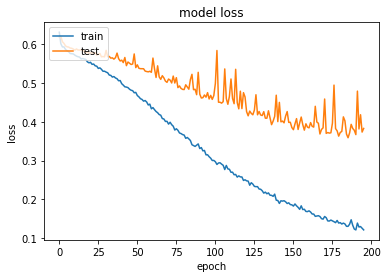

In [196]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving the model

In [197]:
# Saving the model.json

import json
model_json = model.to_json()
with open("../models/model.json", "w") as json_file:
    json_file.write(model_json)

# Loading the model

In [198]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('../models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("../models/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 86.69%


# Predicting emotions on the test data

In [206]:
len(data2_df)

3917

In [207]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 3917/3917 [02:55<00:00, 22.32it/s]


In [208]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

3917/3917 [==============================] - ETA: 11:0 - ETA: 2:1 - ETA: 1: - ETA: 51s - ETA: 37 - ETA: 28 - ETA: 23 - ETA: 19 - ETA: 16 - ETA: 13 - ETA: 12 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 1ms/step


In [209]:
preds1=preds.argmax(axis=1)

In [210]:
abc = preds1.astype(int).flatten()

In [211]:
predictions = (lb.inverse_transform((abc)))

C:\Users\biswsu1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [212]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_negative
1,male_negative
2,male_negative
3,male_positive
4,male_positive
5,male_negative
6,male_negative
7,male_negative
8,male_negative
9,male_negative


In [213]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

C:\Users\biswsu1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [214]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_negative
1,male_negative
2,male_negative
3,male_positive
4,male_positive
5,male_negative
6,male_negative
7,male_negative
8,male_negative
9,male_negative


In [215]:
finaldf = actualdf.join(preddf)

# Actual vs Predicted Emotions

In [216]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_negative
21,male_negative,male_negative
22,male_negative,male_negative
23,male_negative,male_negative
24,male_negative,male_negative
25,male_positive,male_negative
26,male_positive,male_positive
27,male_negative,male_negative
28,male_negative,male_negative
29,male_negative,male_negative


In [217]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,2676
male_positive,1241


In [218]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,3031
male_positive,886


In [219]:
finaldf.to_csv('Predictions.csv', index=False)

In [220]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [221]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

89.35409752361501

In [222]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

86.5440531176545

In [228]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='macro')# *100

(0.9188302886724315, 0.838688030651784, 0.865440531176545, None)

In [223]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[2645,   31],
       [ 386,  855]], dtype=int64)

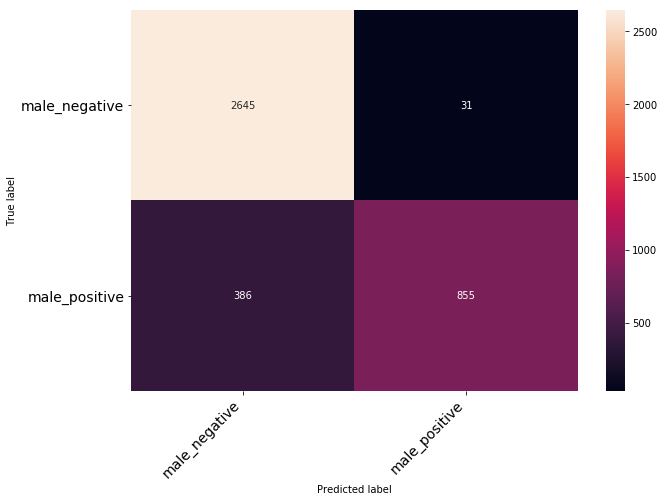

In [224]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)